# Neurális hálózatok

In [2]:
!pip install keract

Defaulting to user installation because normal site-packages is not writeable


In [21]:
#1 Set up packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # 0.23.2

import tensorflow as tf # 2.4.0
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical # One-hot kódolás
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from keract import get_activations, display_activations
from keract.keract import display_heatmaps

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.disable_eager_execution()
sns.set(style='white', context='notebook', palette='deep')

## Adatok betöltése

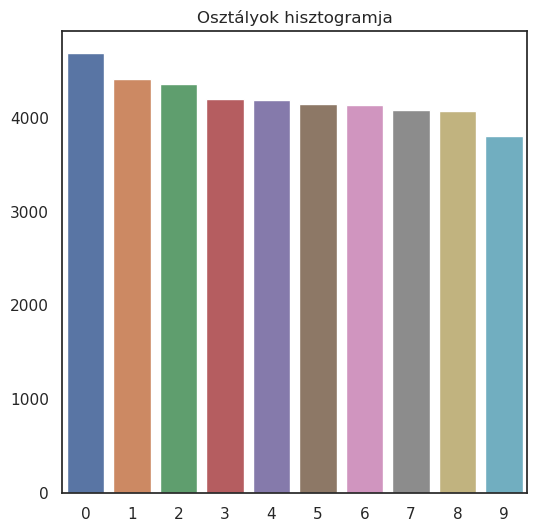

In [23]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Y_train = train["label"]
X_train = train.drop("label", axis=1) 

hist = Y_train.value_counts()
plt.figure(figsize=(6, 6))
plt.title('Osztályok hisztogramja')
sns.barplot(x=np.arange(len(hist)), y=hist)
plt.ylabel('')
plt.show()

## Számok mutatása egy táblázatban

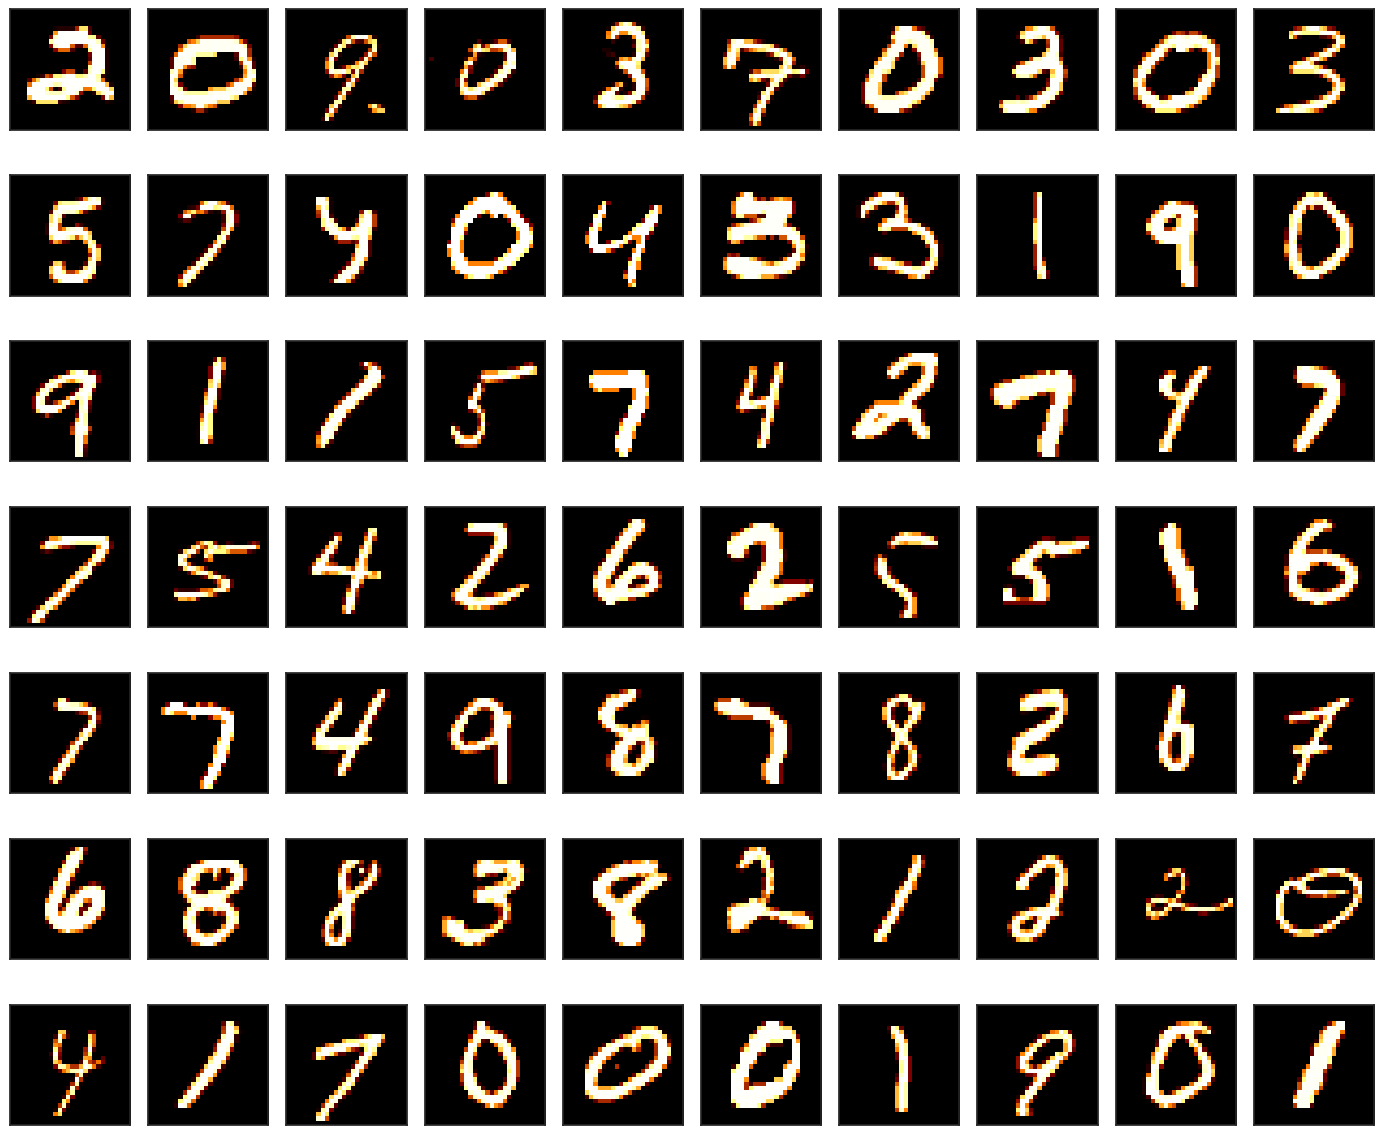

In [24]:
plt.figure(figsize=(14,12))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = test.iloc[digit_num].to_numpy().reshape(28,28)
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

## Null és hiányzó értékek keresése

In [25]:
print(X_train.isnull().any().describe())
print('---------------')
print(test.isnull().any().describe())

count       784
unique        1
top       False
freq        784
dtype: object
---------------
count       784
unique        1
top       False
freq        784
dtype: object


## Előfeldolgozás

In [26]:
# Normalizálás
X_train = X_train / 255.0
test = test / 255.0

# Átalakítás 1x28x28x1 -es mátrixokká: a Keras-nak szüksége van egy extra dimenzióra
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Vektorkódolás
Y_train = to_categorical(Y_train, num_classes = 10)

## Tanító-validáció szétválasztás

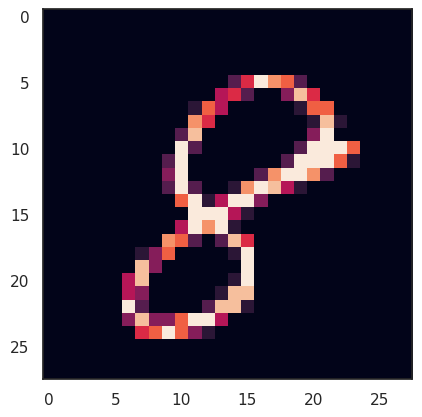

In [27]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

g = plt.imshow(X_train[0][:,:,0])

## Aktivációs függvények vizualizálása

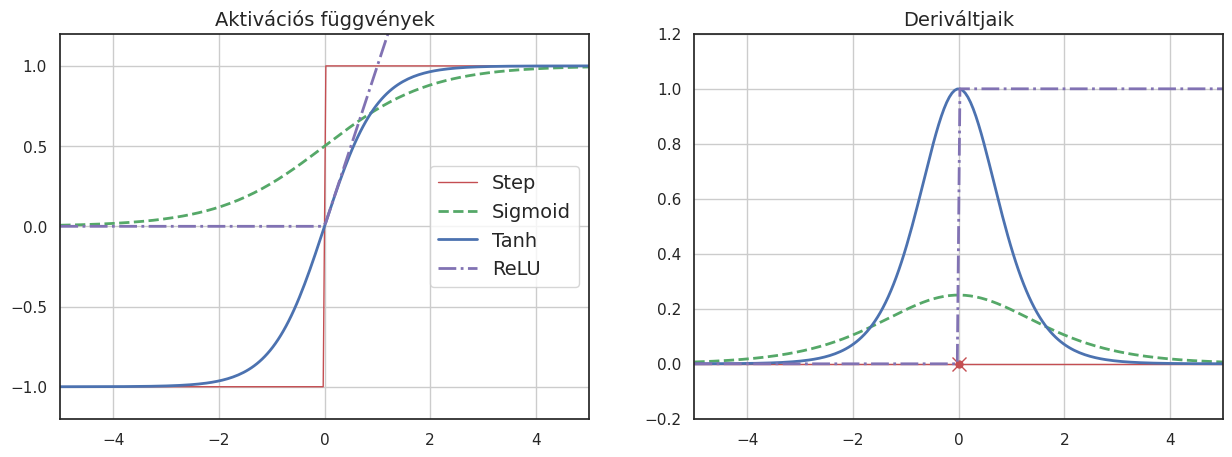

In [28]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Aktivációs függvények", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Deriváltjaik", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Aktivációs függvények a XOR adatokon
Figyeljük meg, hogyan képesek ezek a függvények szétbontani a teret osztályozáshoz

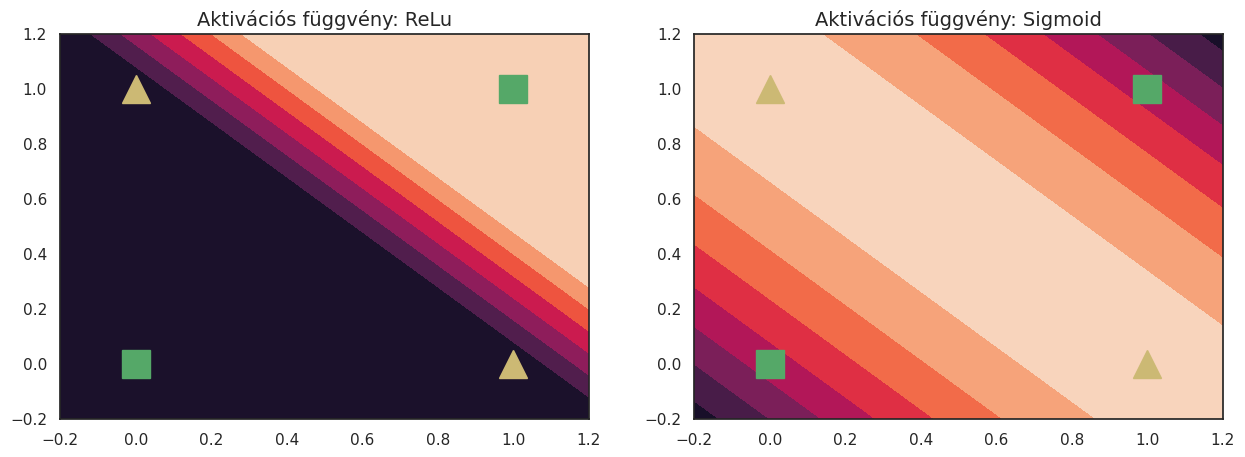

In [29]:
def mlp_xor(x1, x2, activation):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=relu)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Aktivációs függvény: ReLu", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Aktivációs függvény: Sigmoid", fontsize=14)
plt.grid(True)

### Konvolúciós háló (CNN) modell felépítése
Először létrehozzuk a modellt, majd egyesével hozzáadjuk a rétegeket.

In [30]:
## Input -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Output
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax", name='preds')) # Eloszlási valószínűség minden osztályra

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

## Otimalizáló és teljesítmény metrika
Az optimalizáló adja meg azt a módszert, amivel a paraméterek frissítéseit számoljuk.

A teljesítmény mértéke a kategorikus keresztentrópia, ami alkalmas multiclass osztályozáshoz.

In [31]:
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate = 0.001, rho = 0.9, epsilon = 1e-08)

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

## Rétegek vizualizálása

(1, 28, 28, 1)
(1, 28, 28, 1)
conv2d_4_input (1, 28, 28, 1) 


2024-01-01 20:39:38.872339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-01 20:39:38.898558: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_5/kernel/Assign' id:293 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_5/kernel, conv2d_5/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


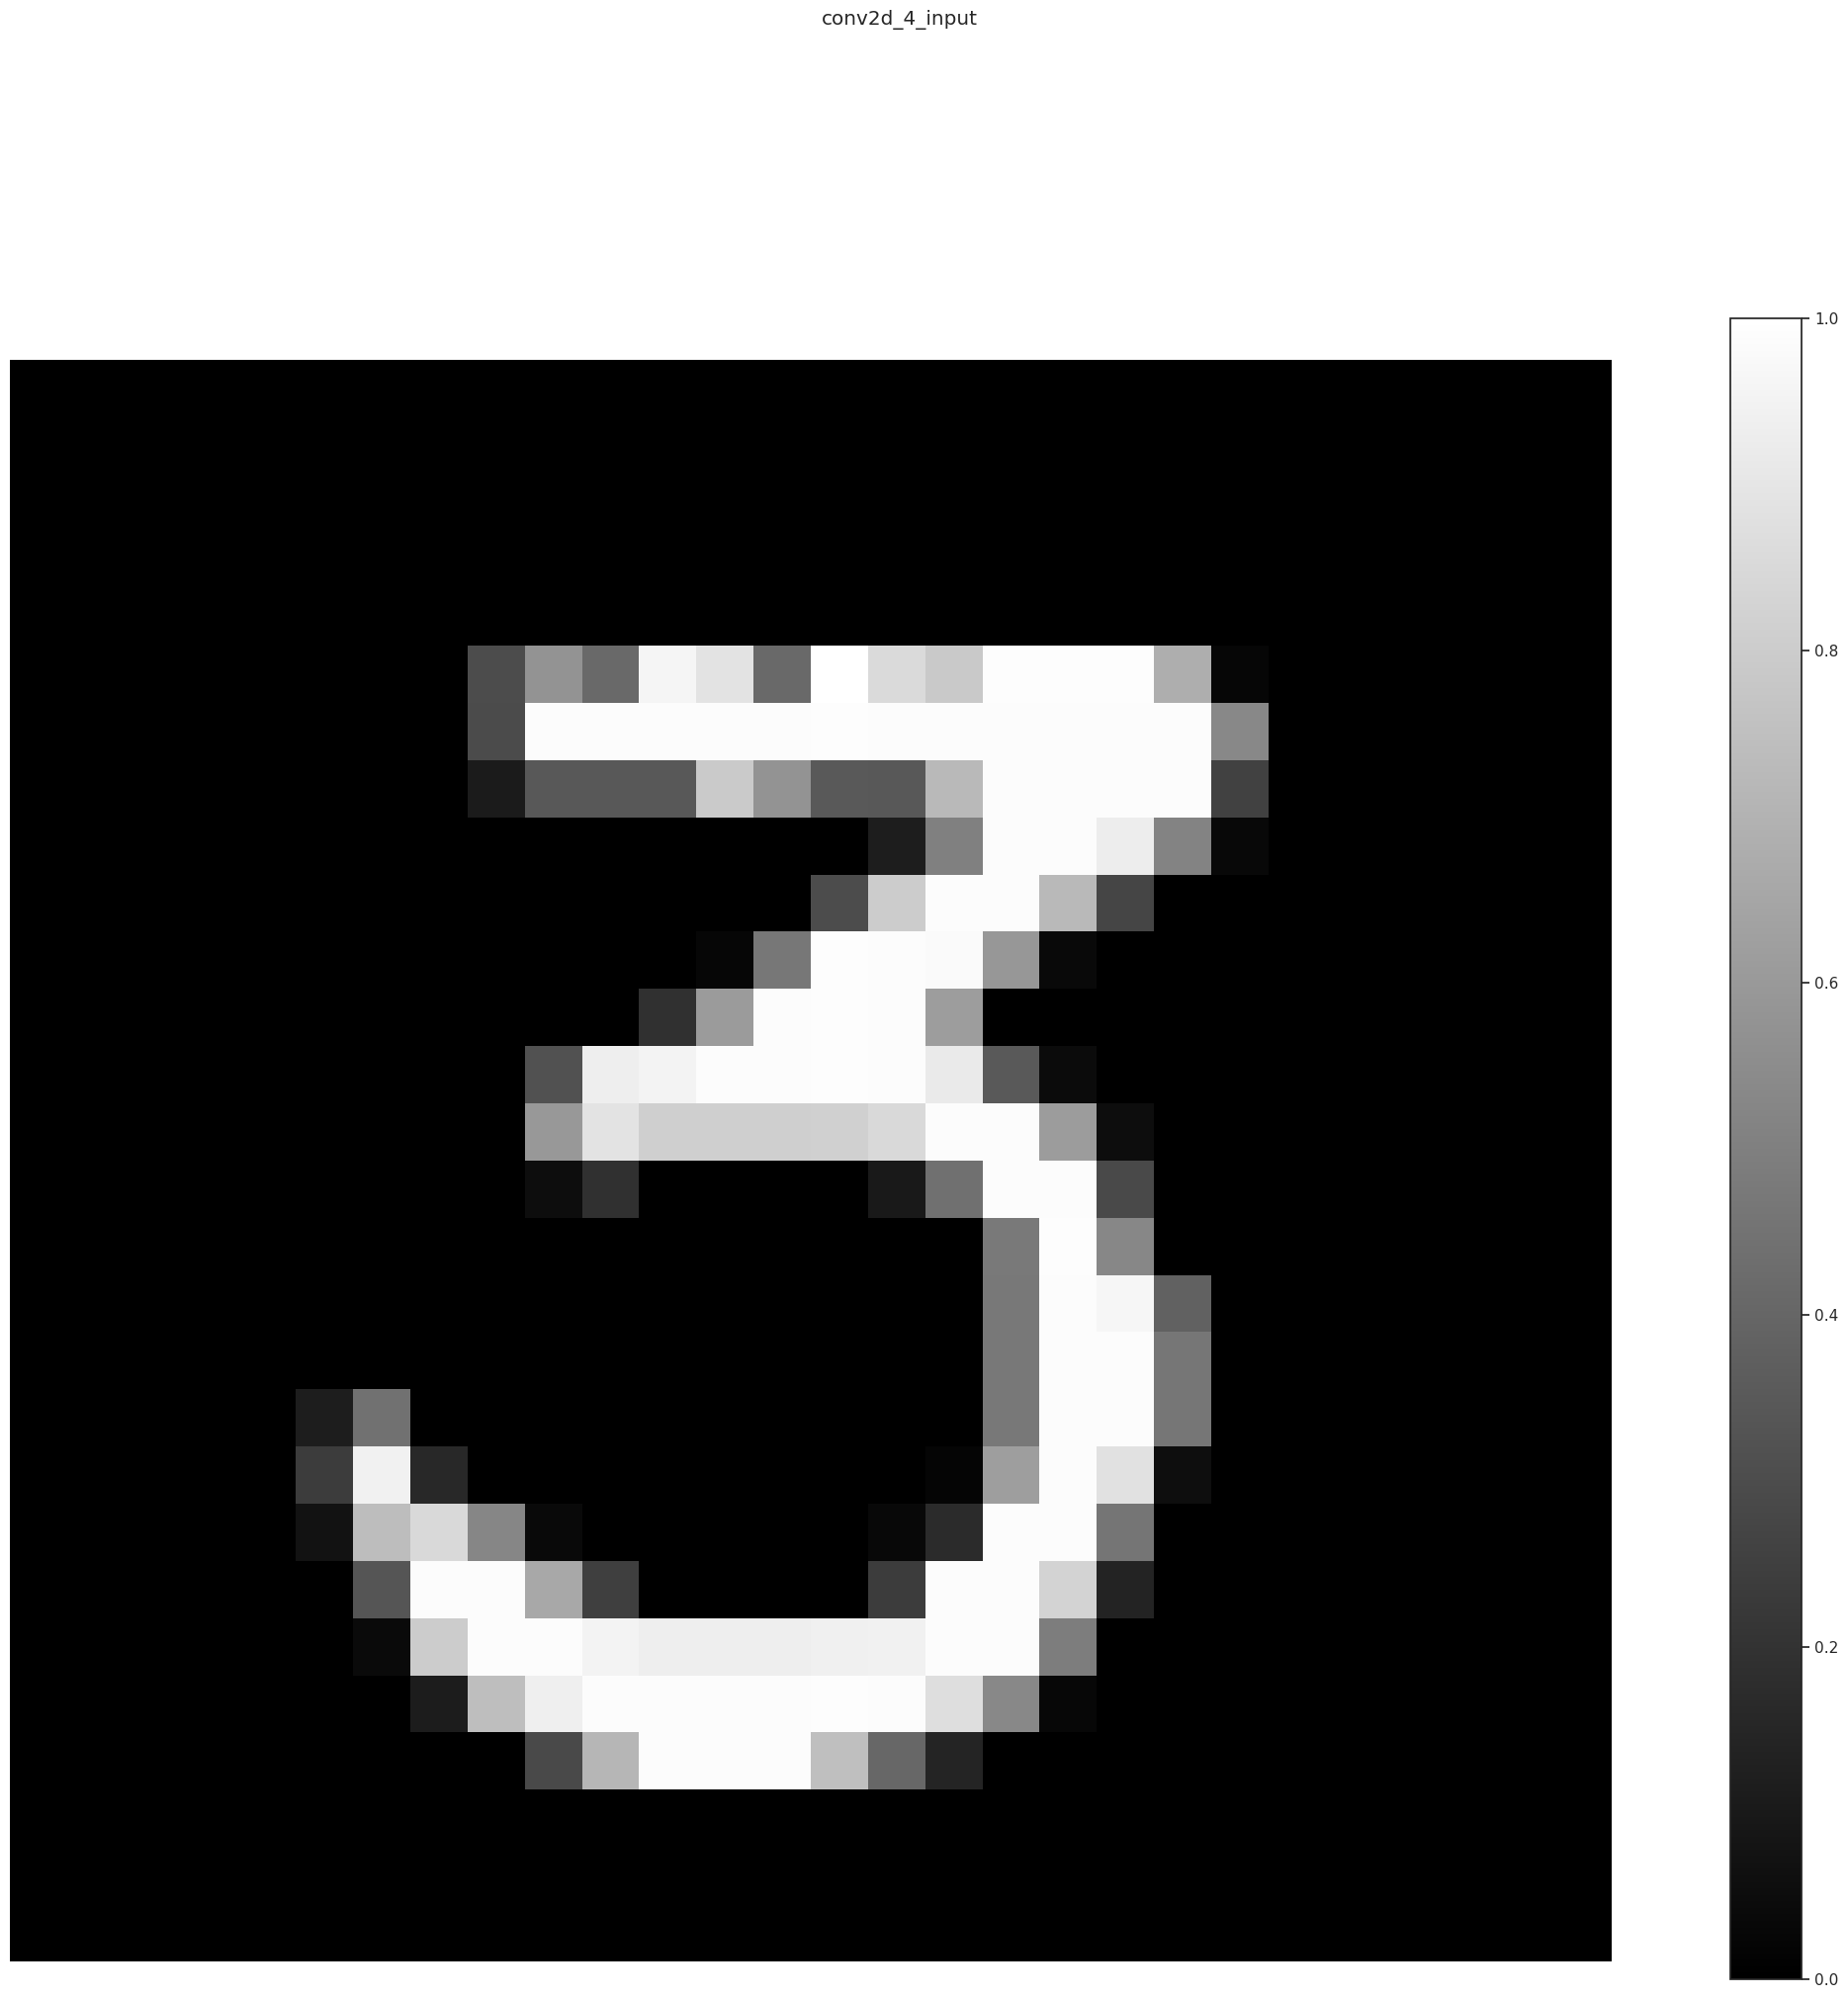

conv2d_4 (1, 28, 28, 32) 


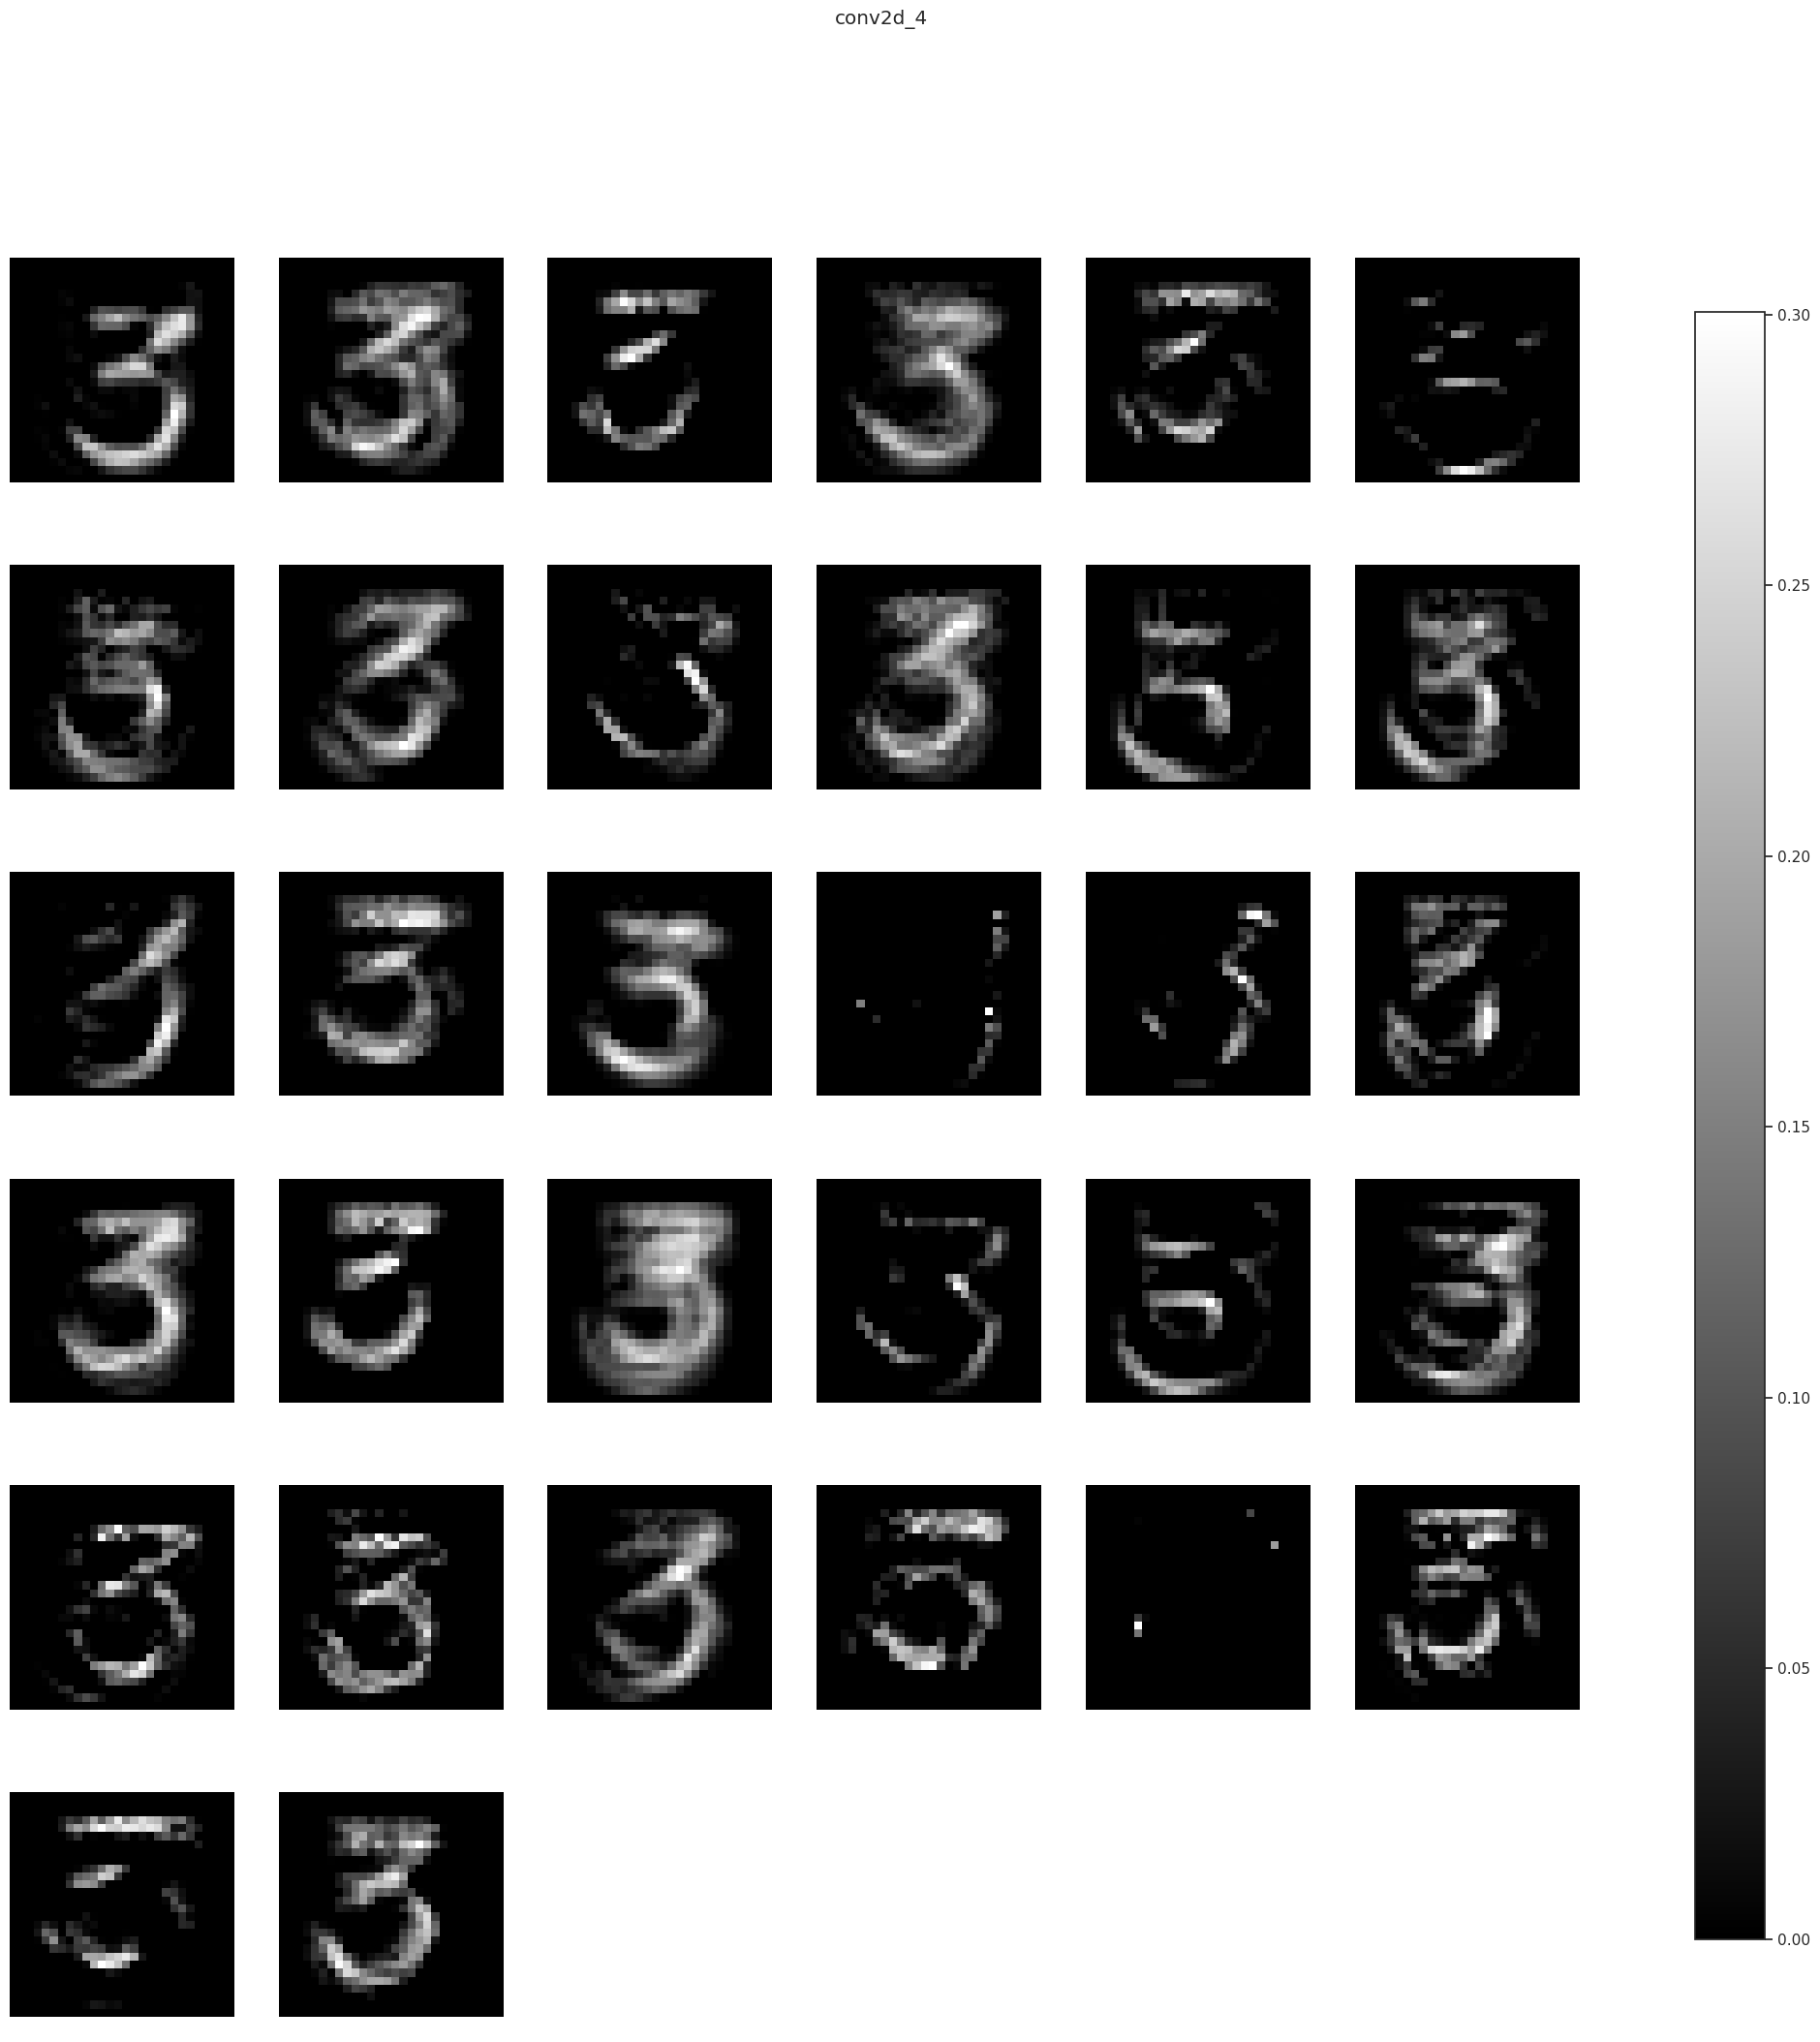

conv2d_5 (1, 28, 28, 32) 


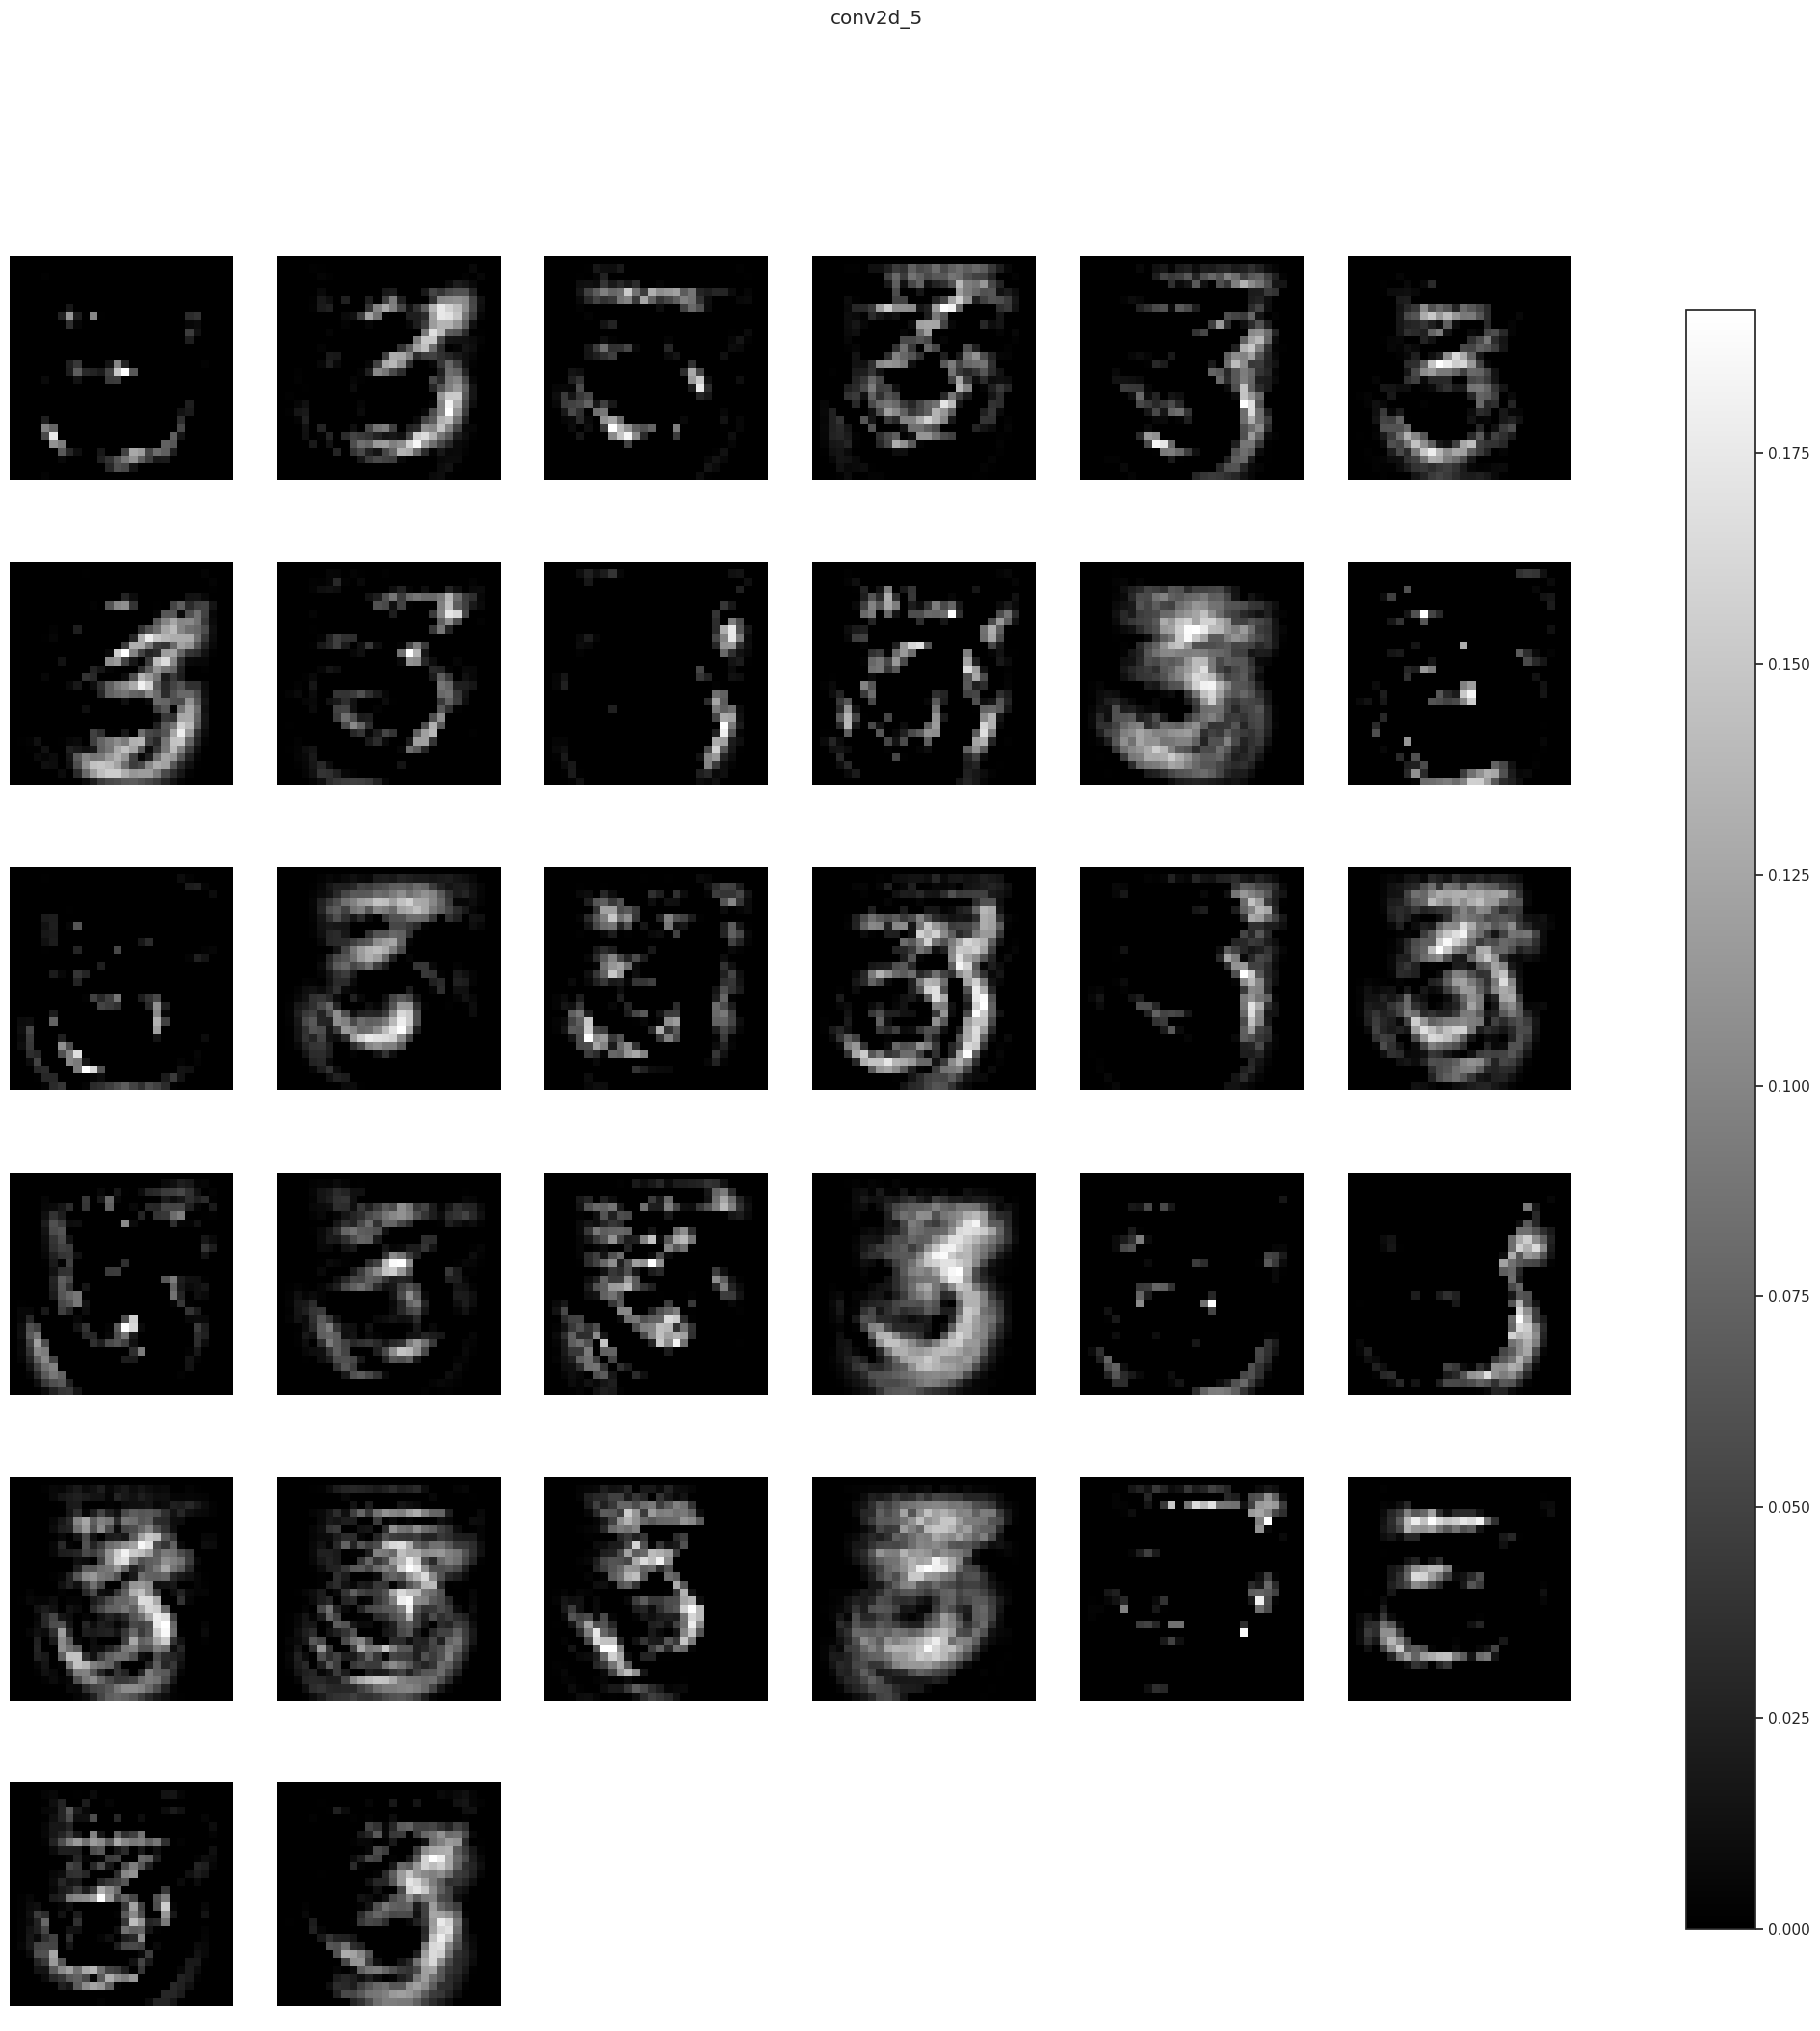

max_pooling2d_2 (1, 14, 14, 32) 


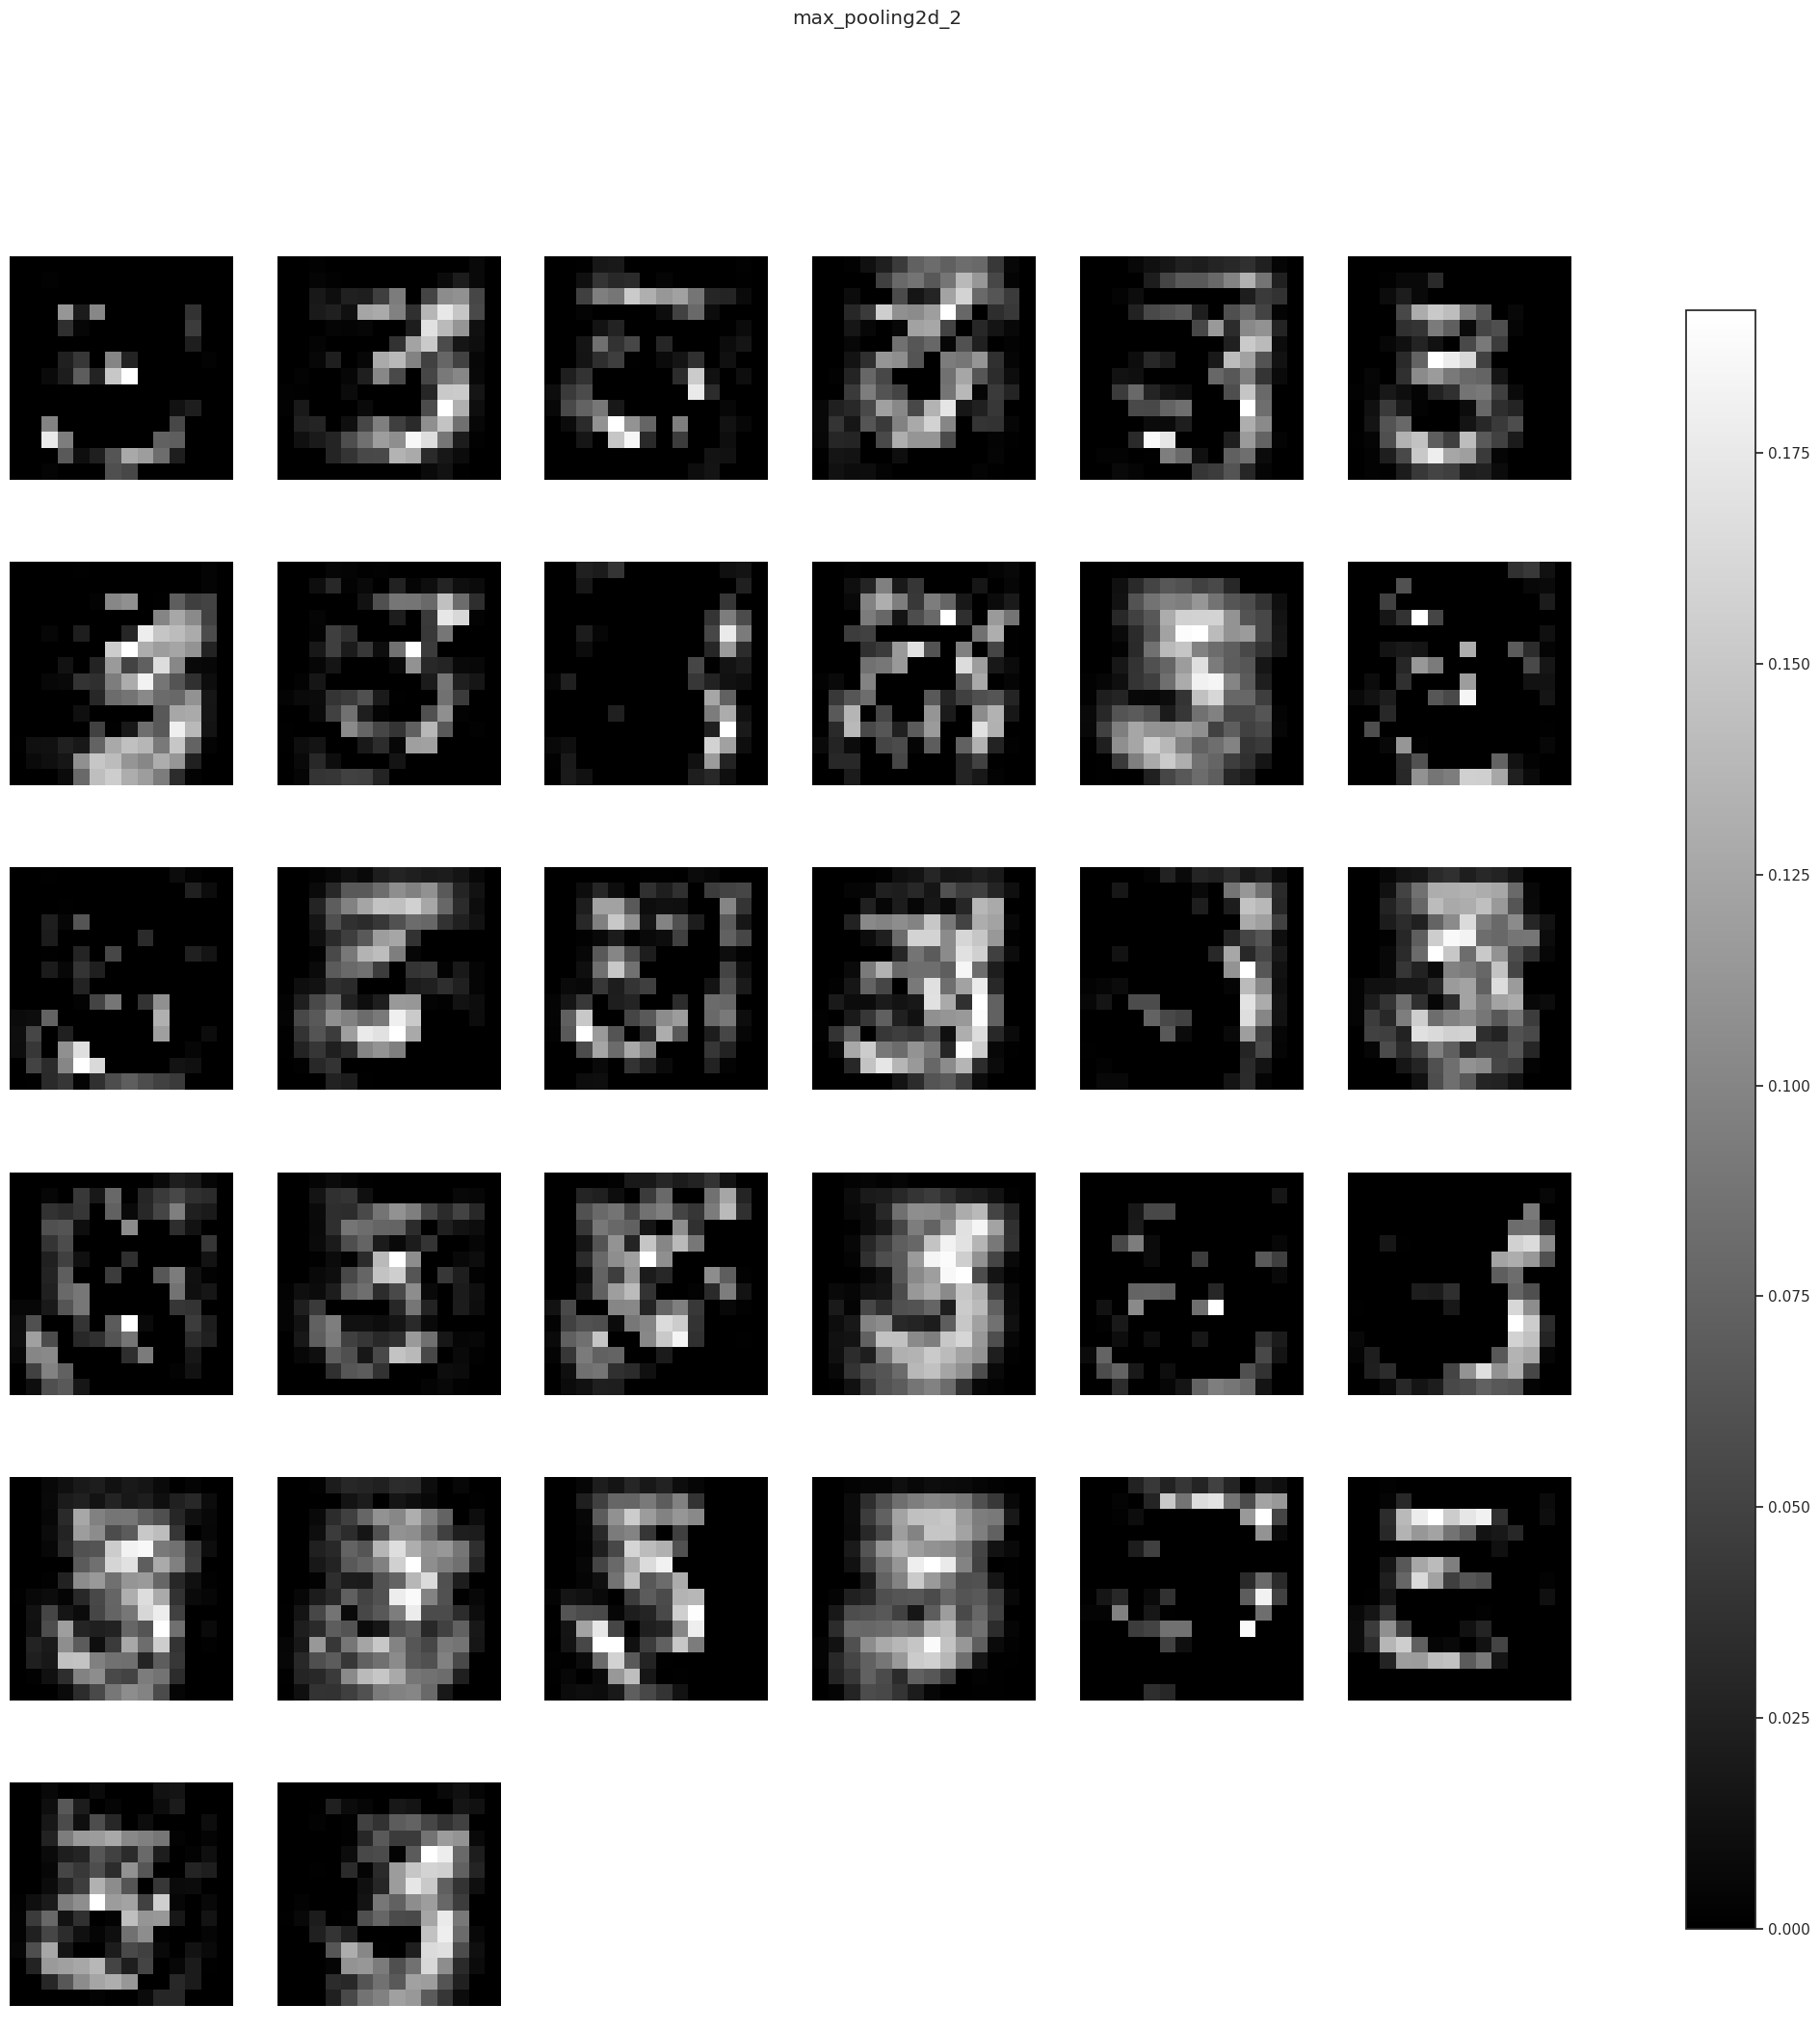

dropout_3 (1, 14, 14, 32) 


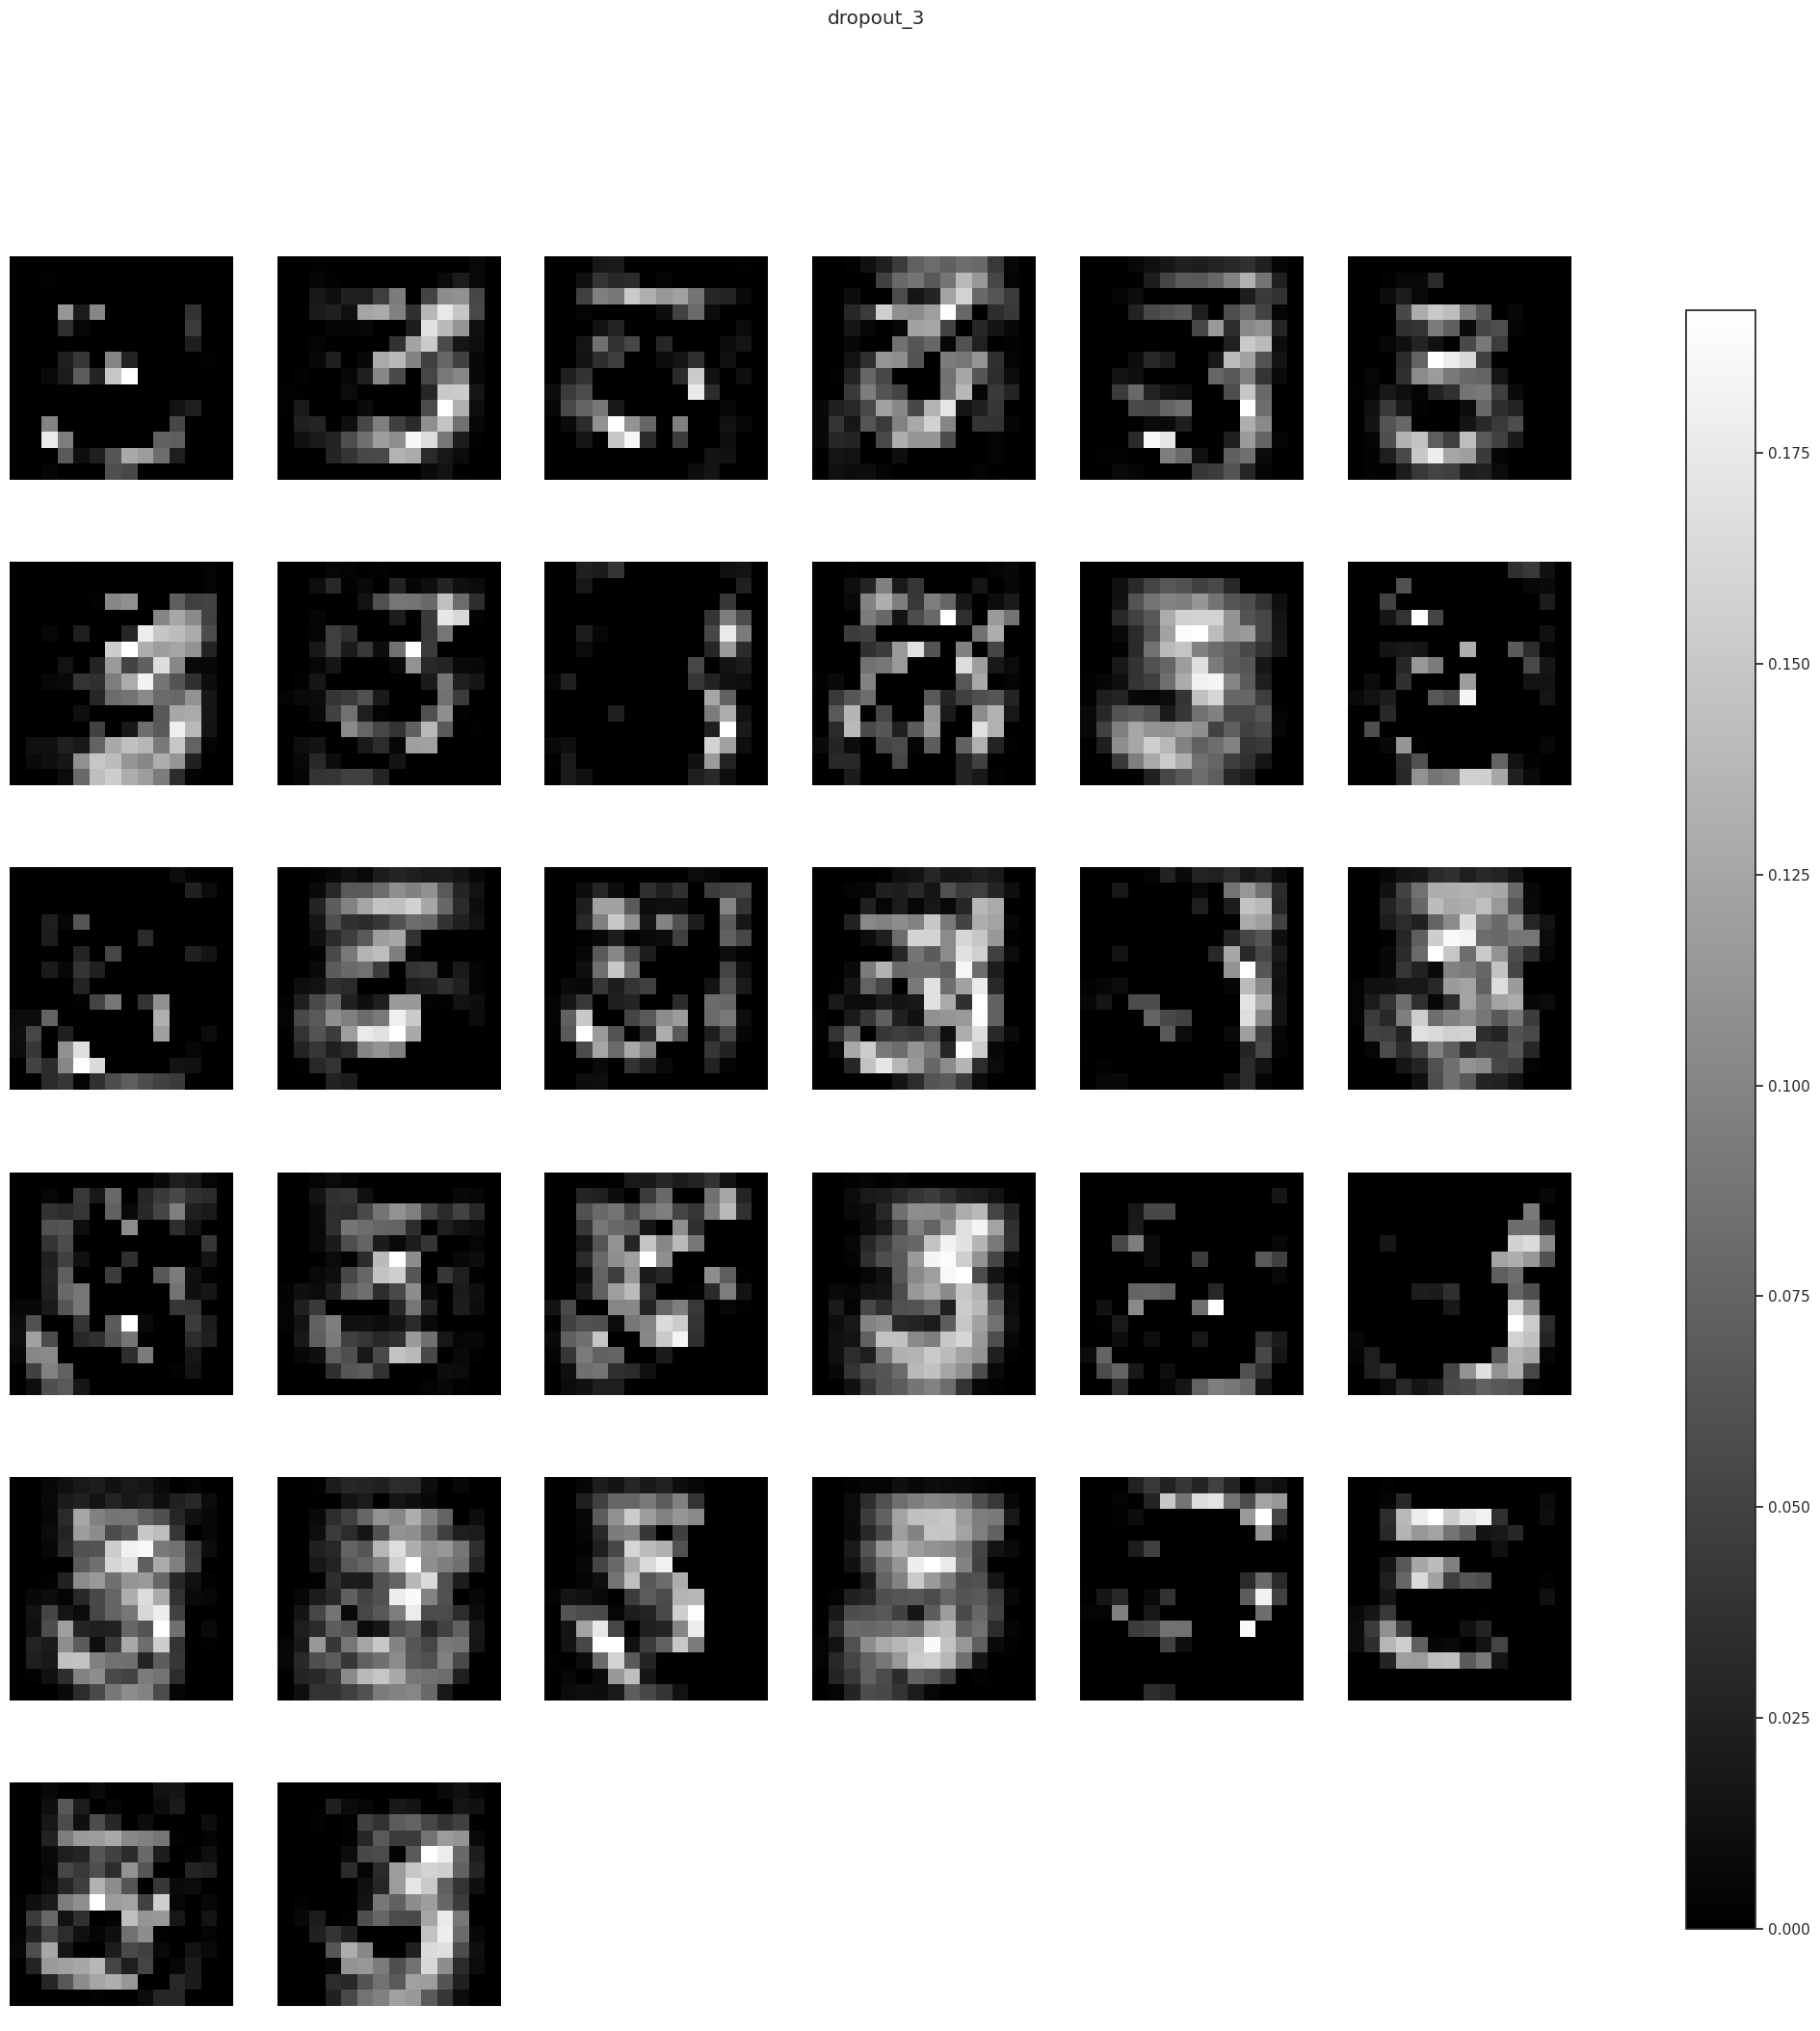

conv2d_6 (1, 14, 14, 64) 


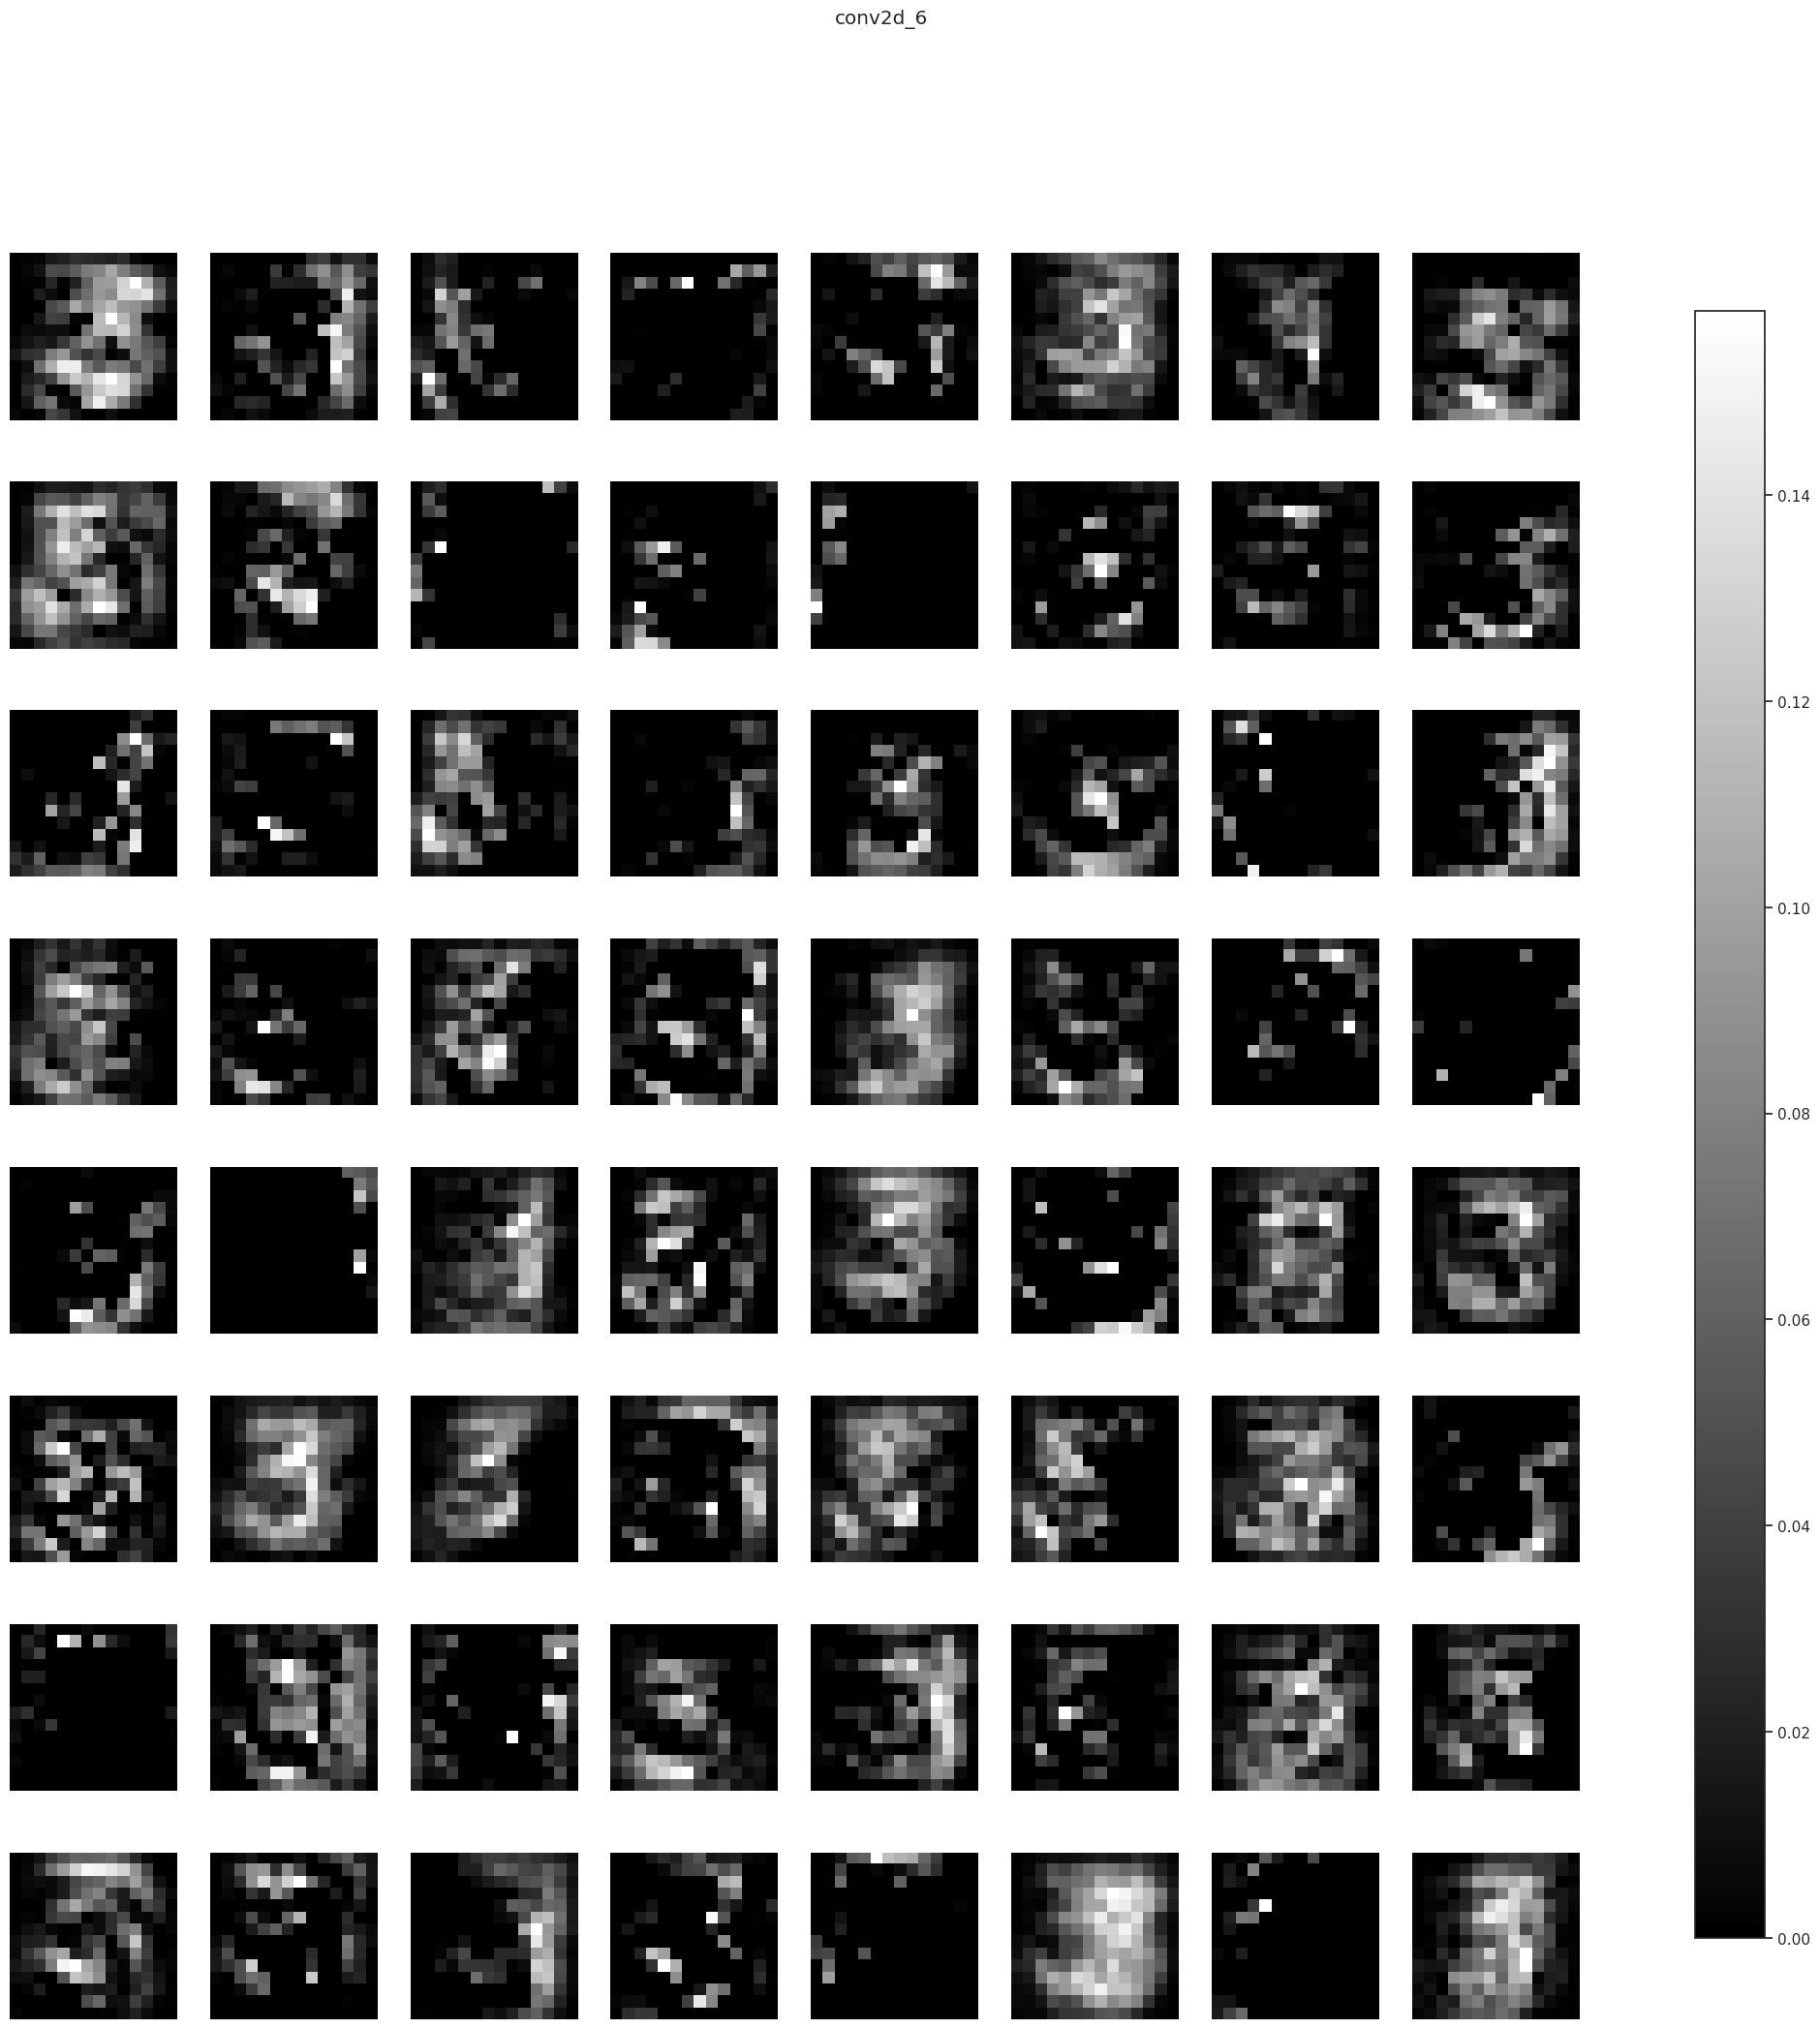

conv2d_7 (1, 14, 14, 64) 


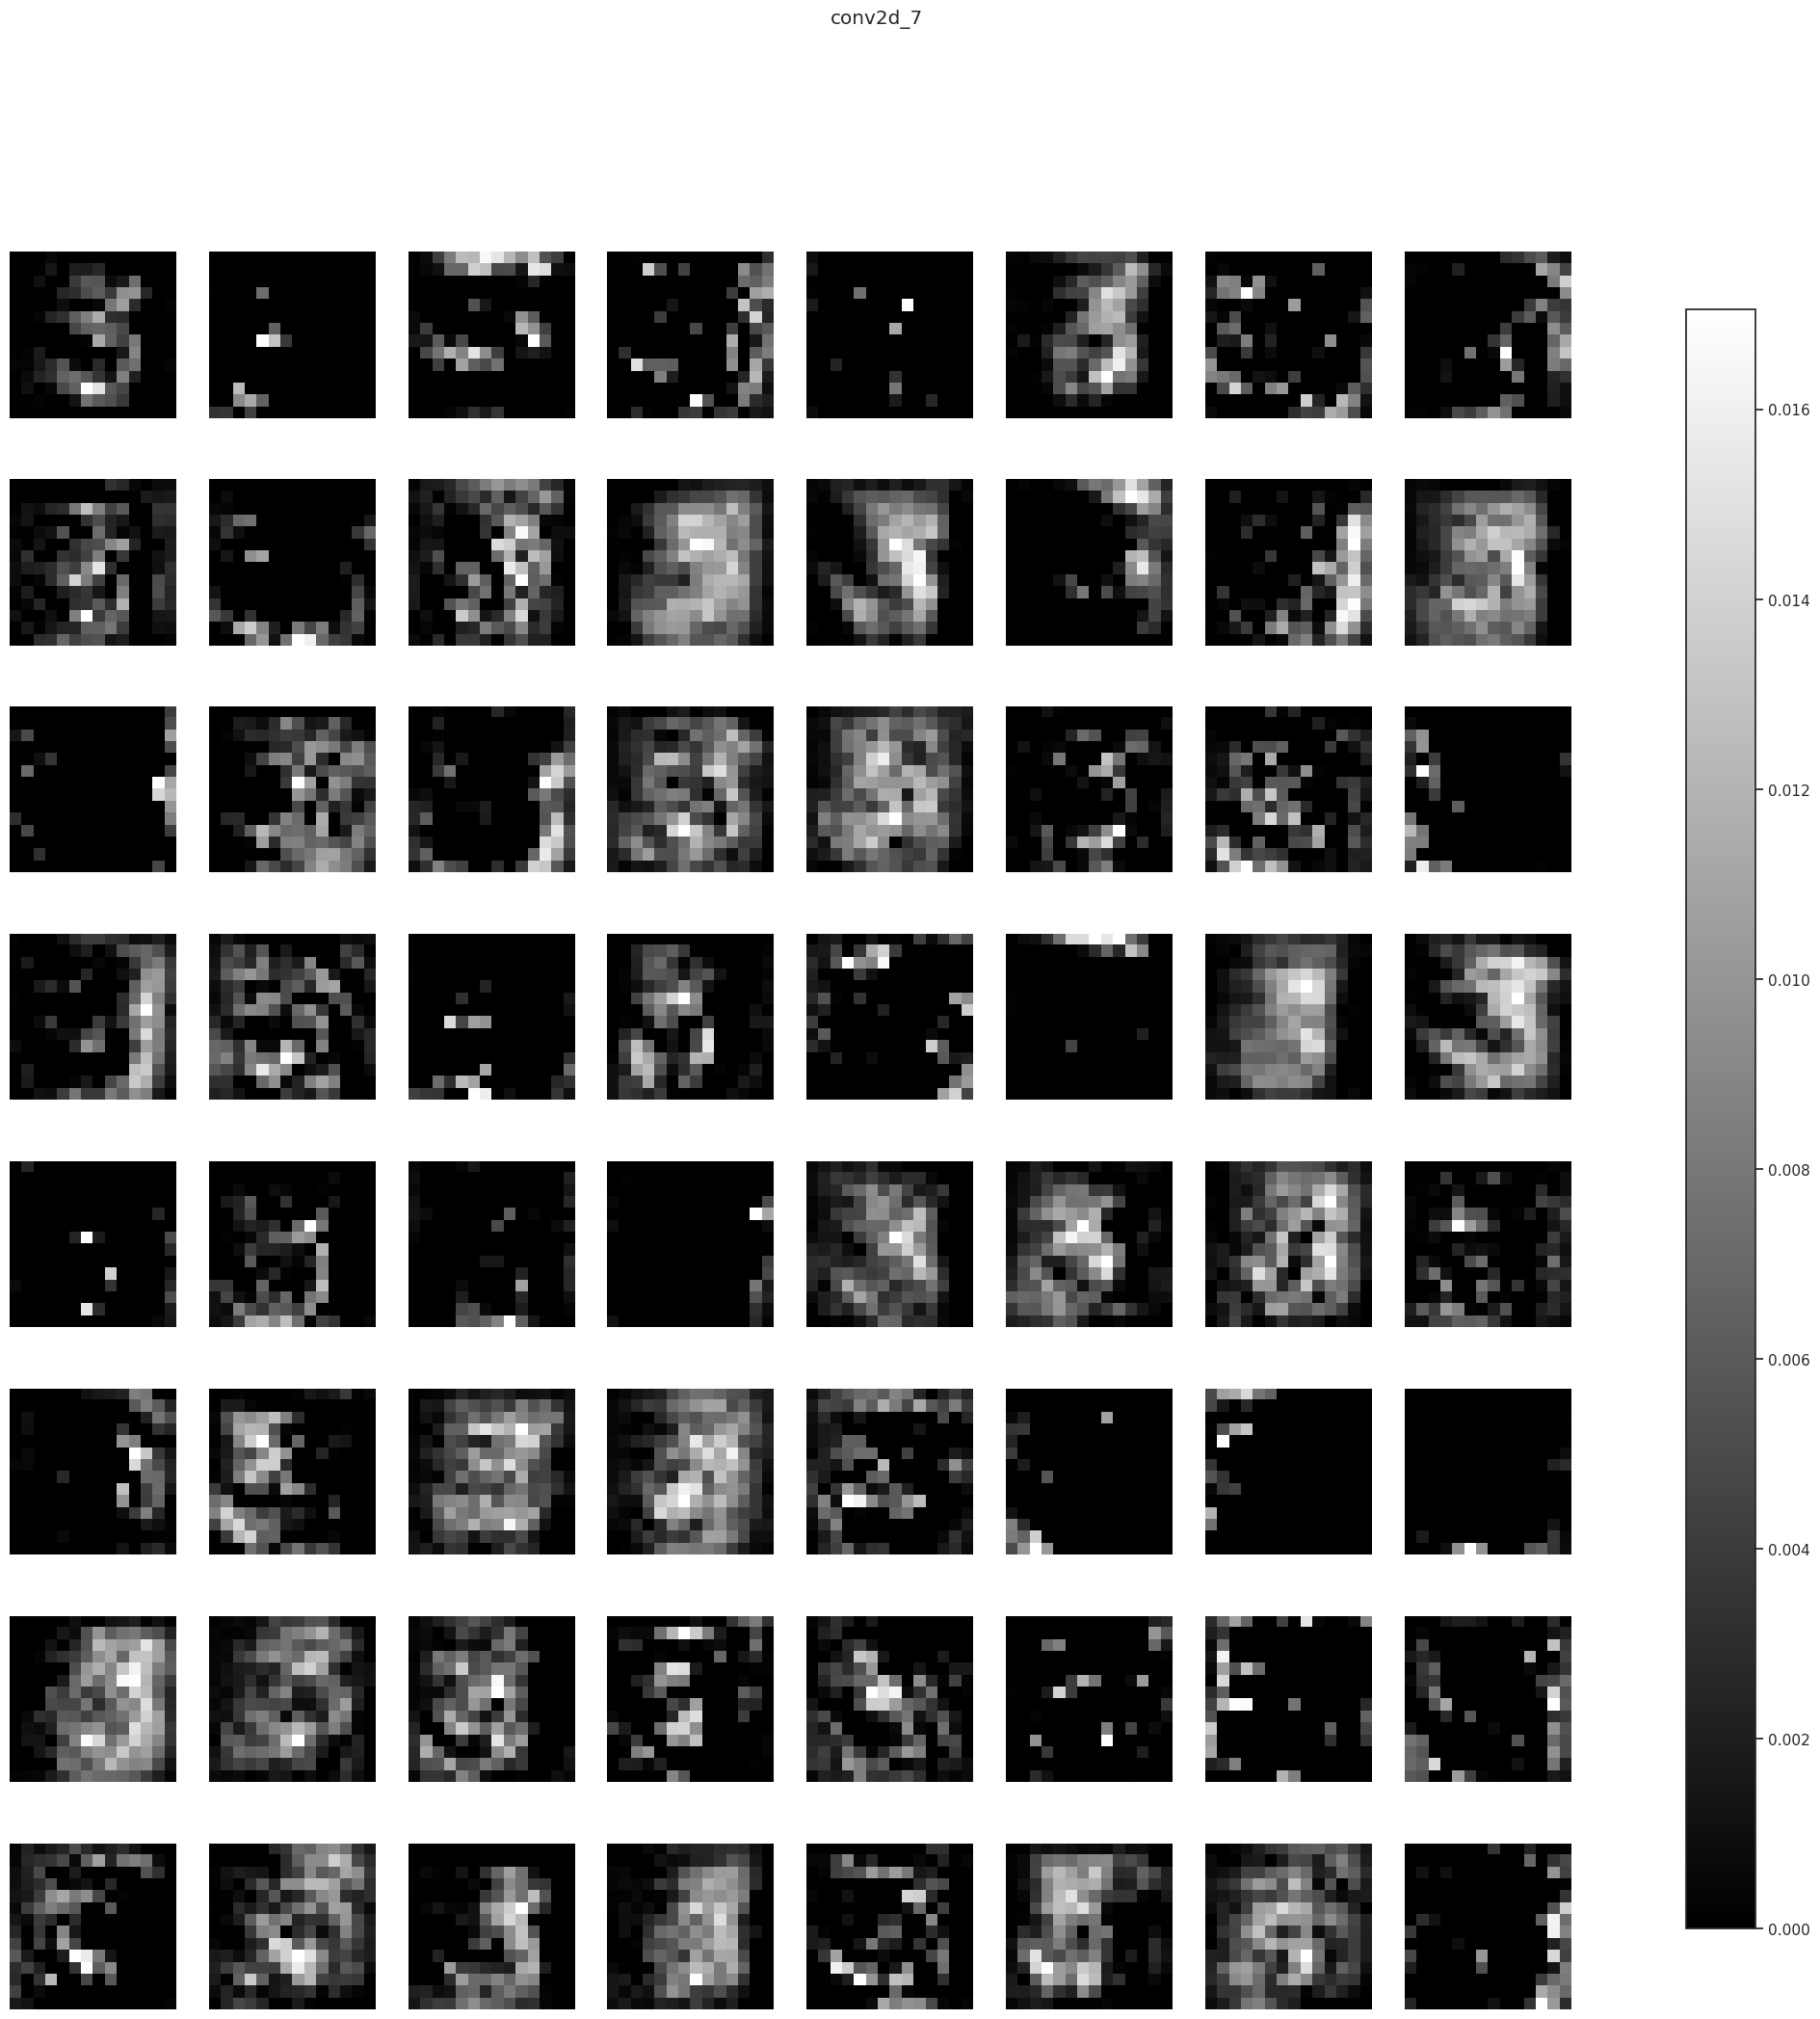

max_pooling2d_3 (1, 7, 7, 64) 


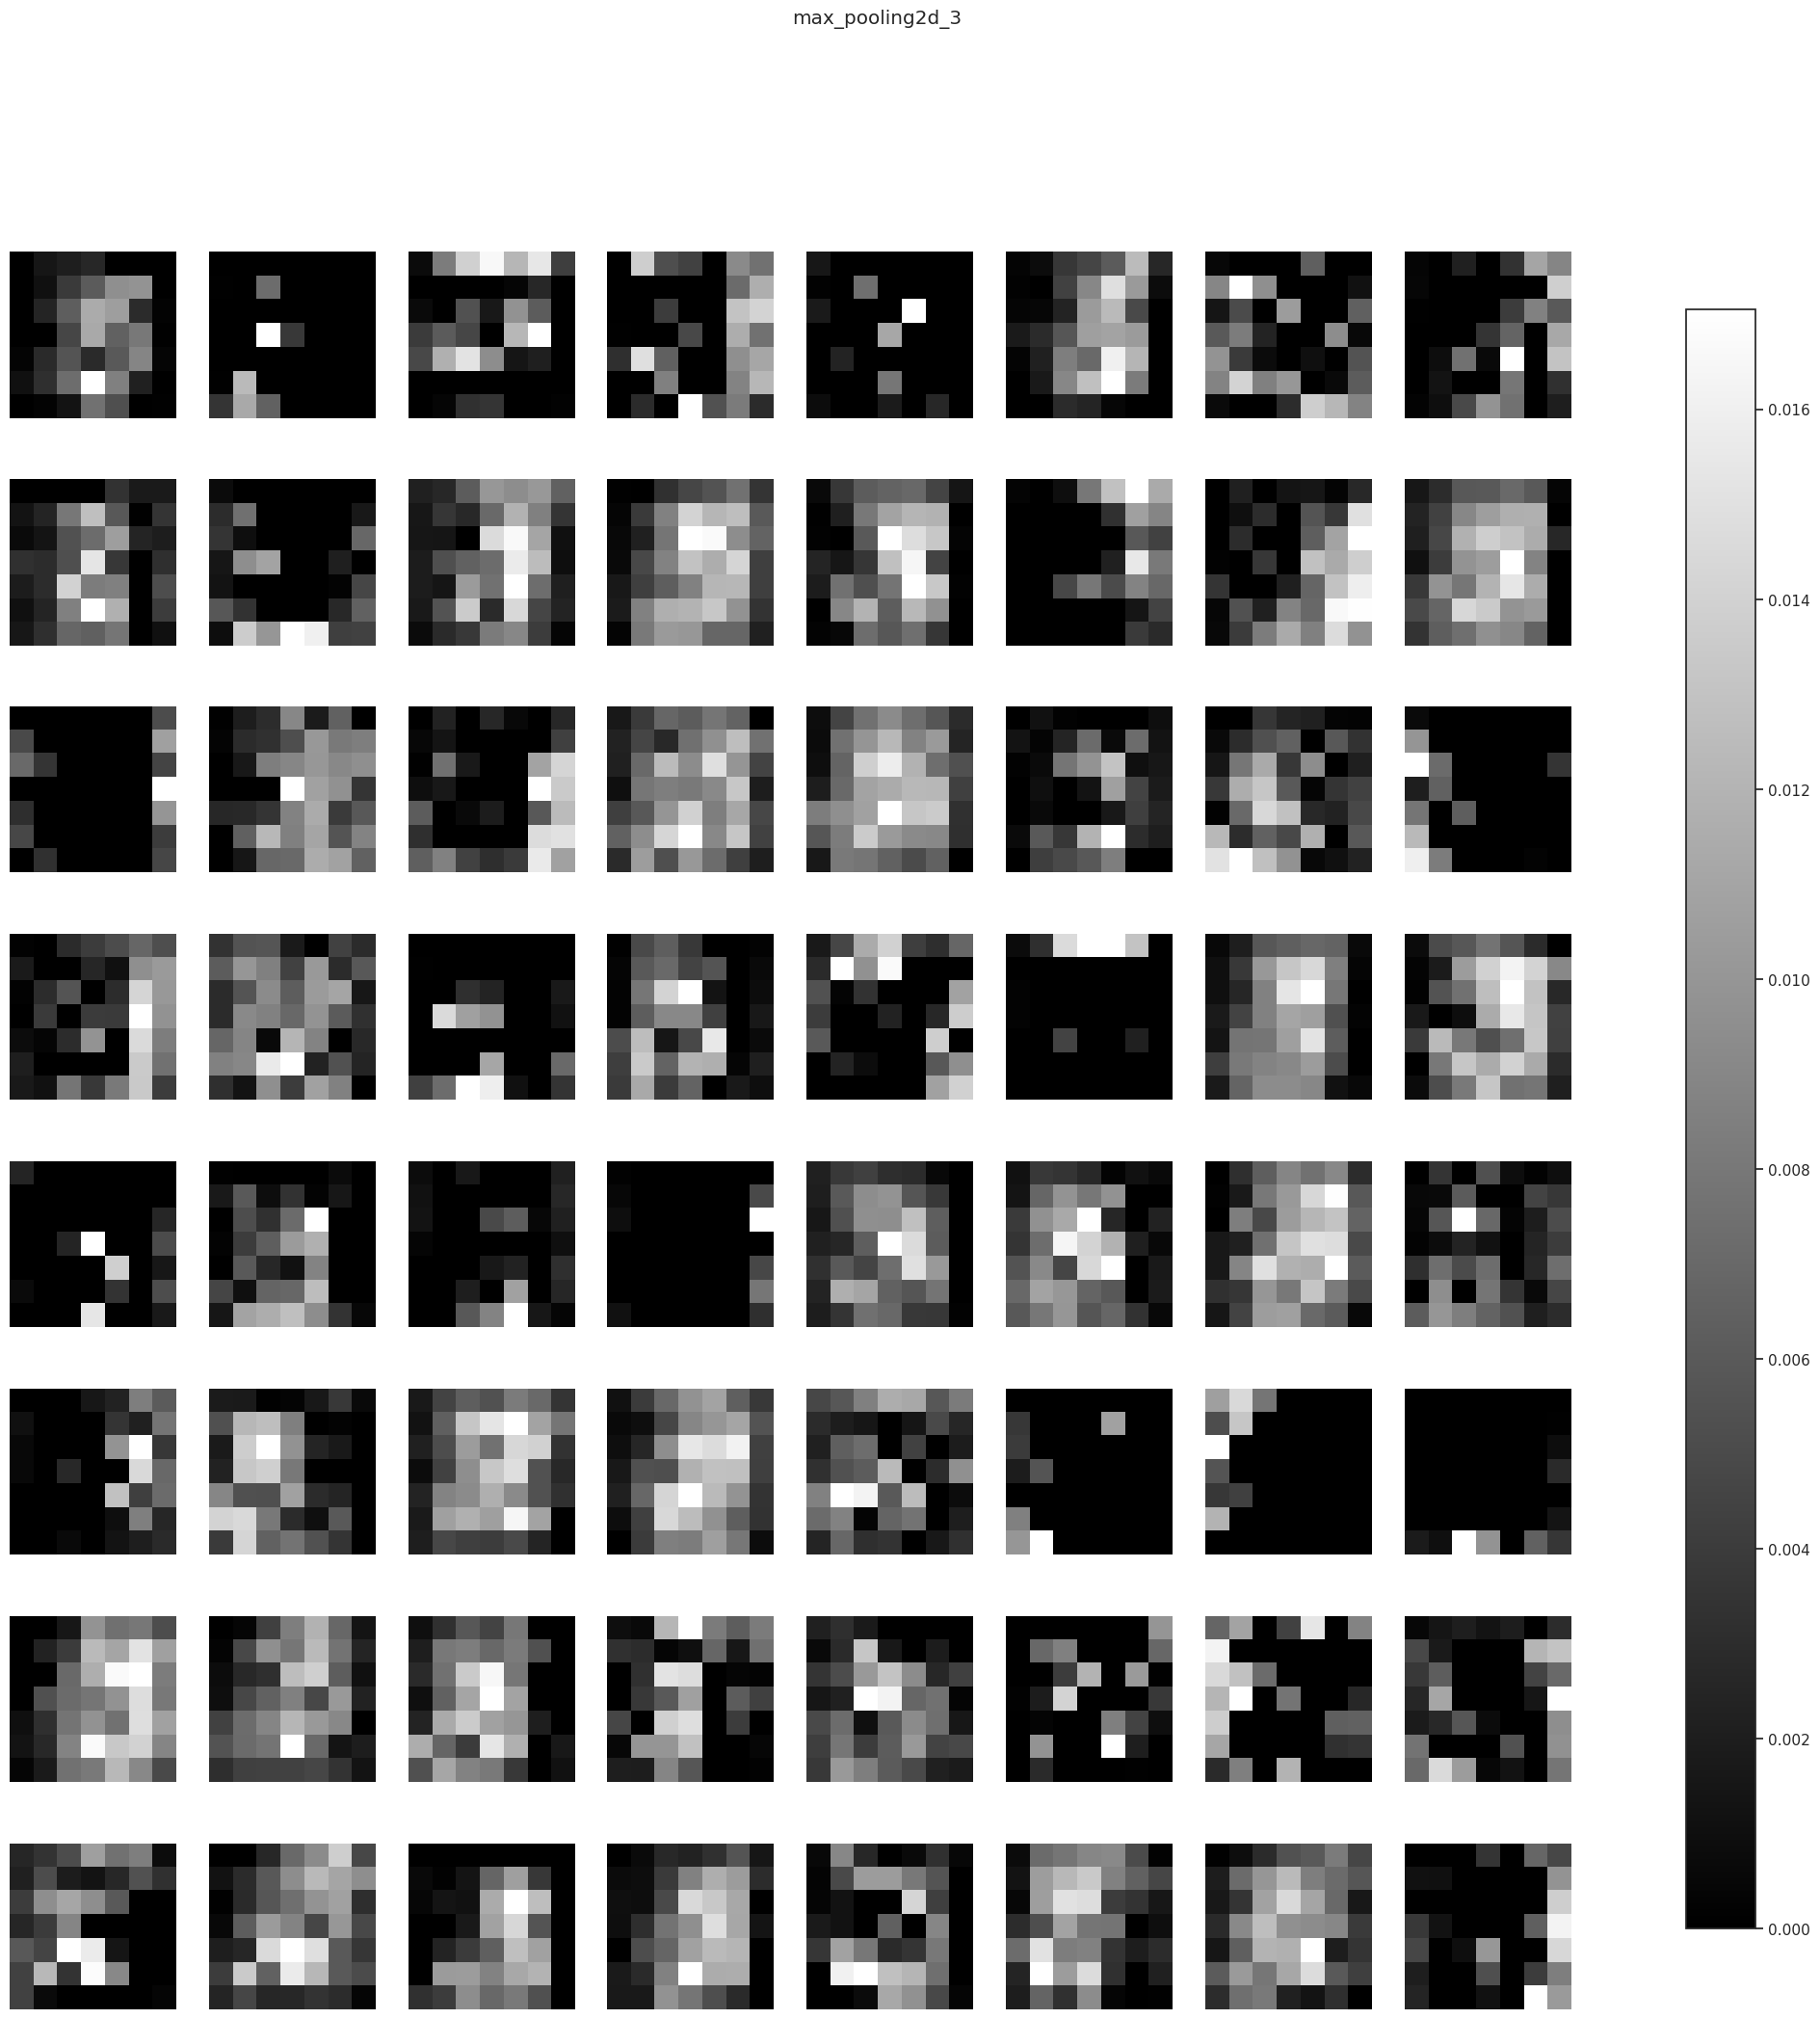

dropout_4 (1, 7, 7, 64) 


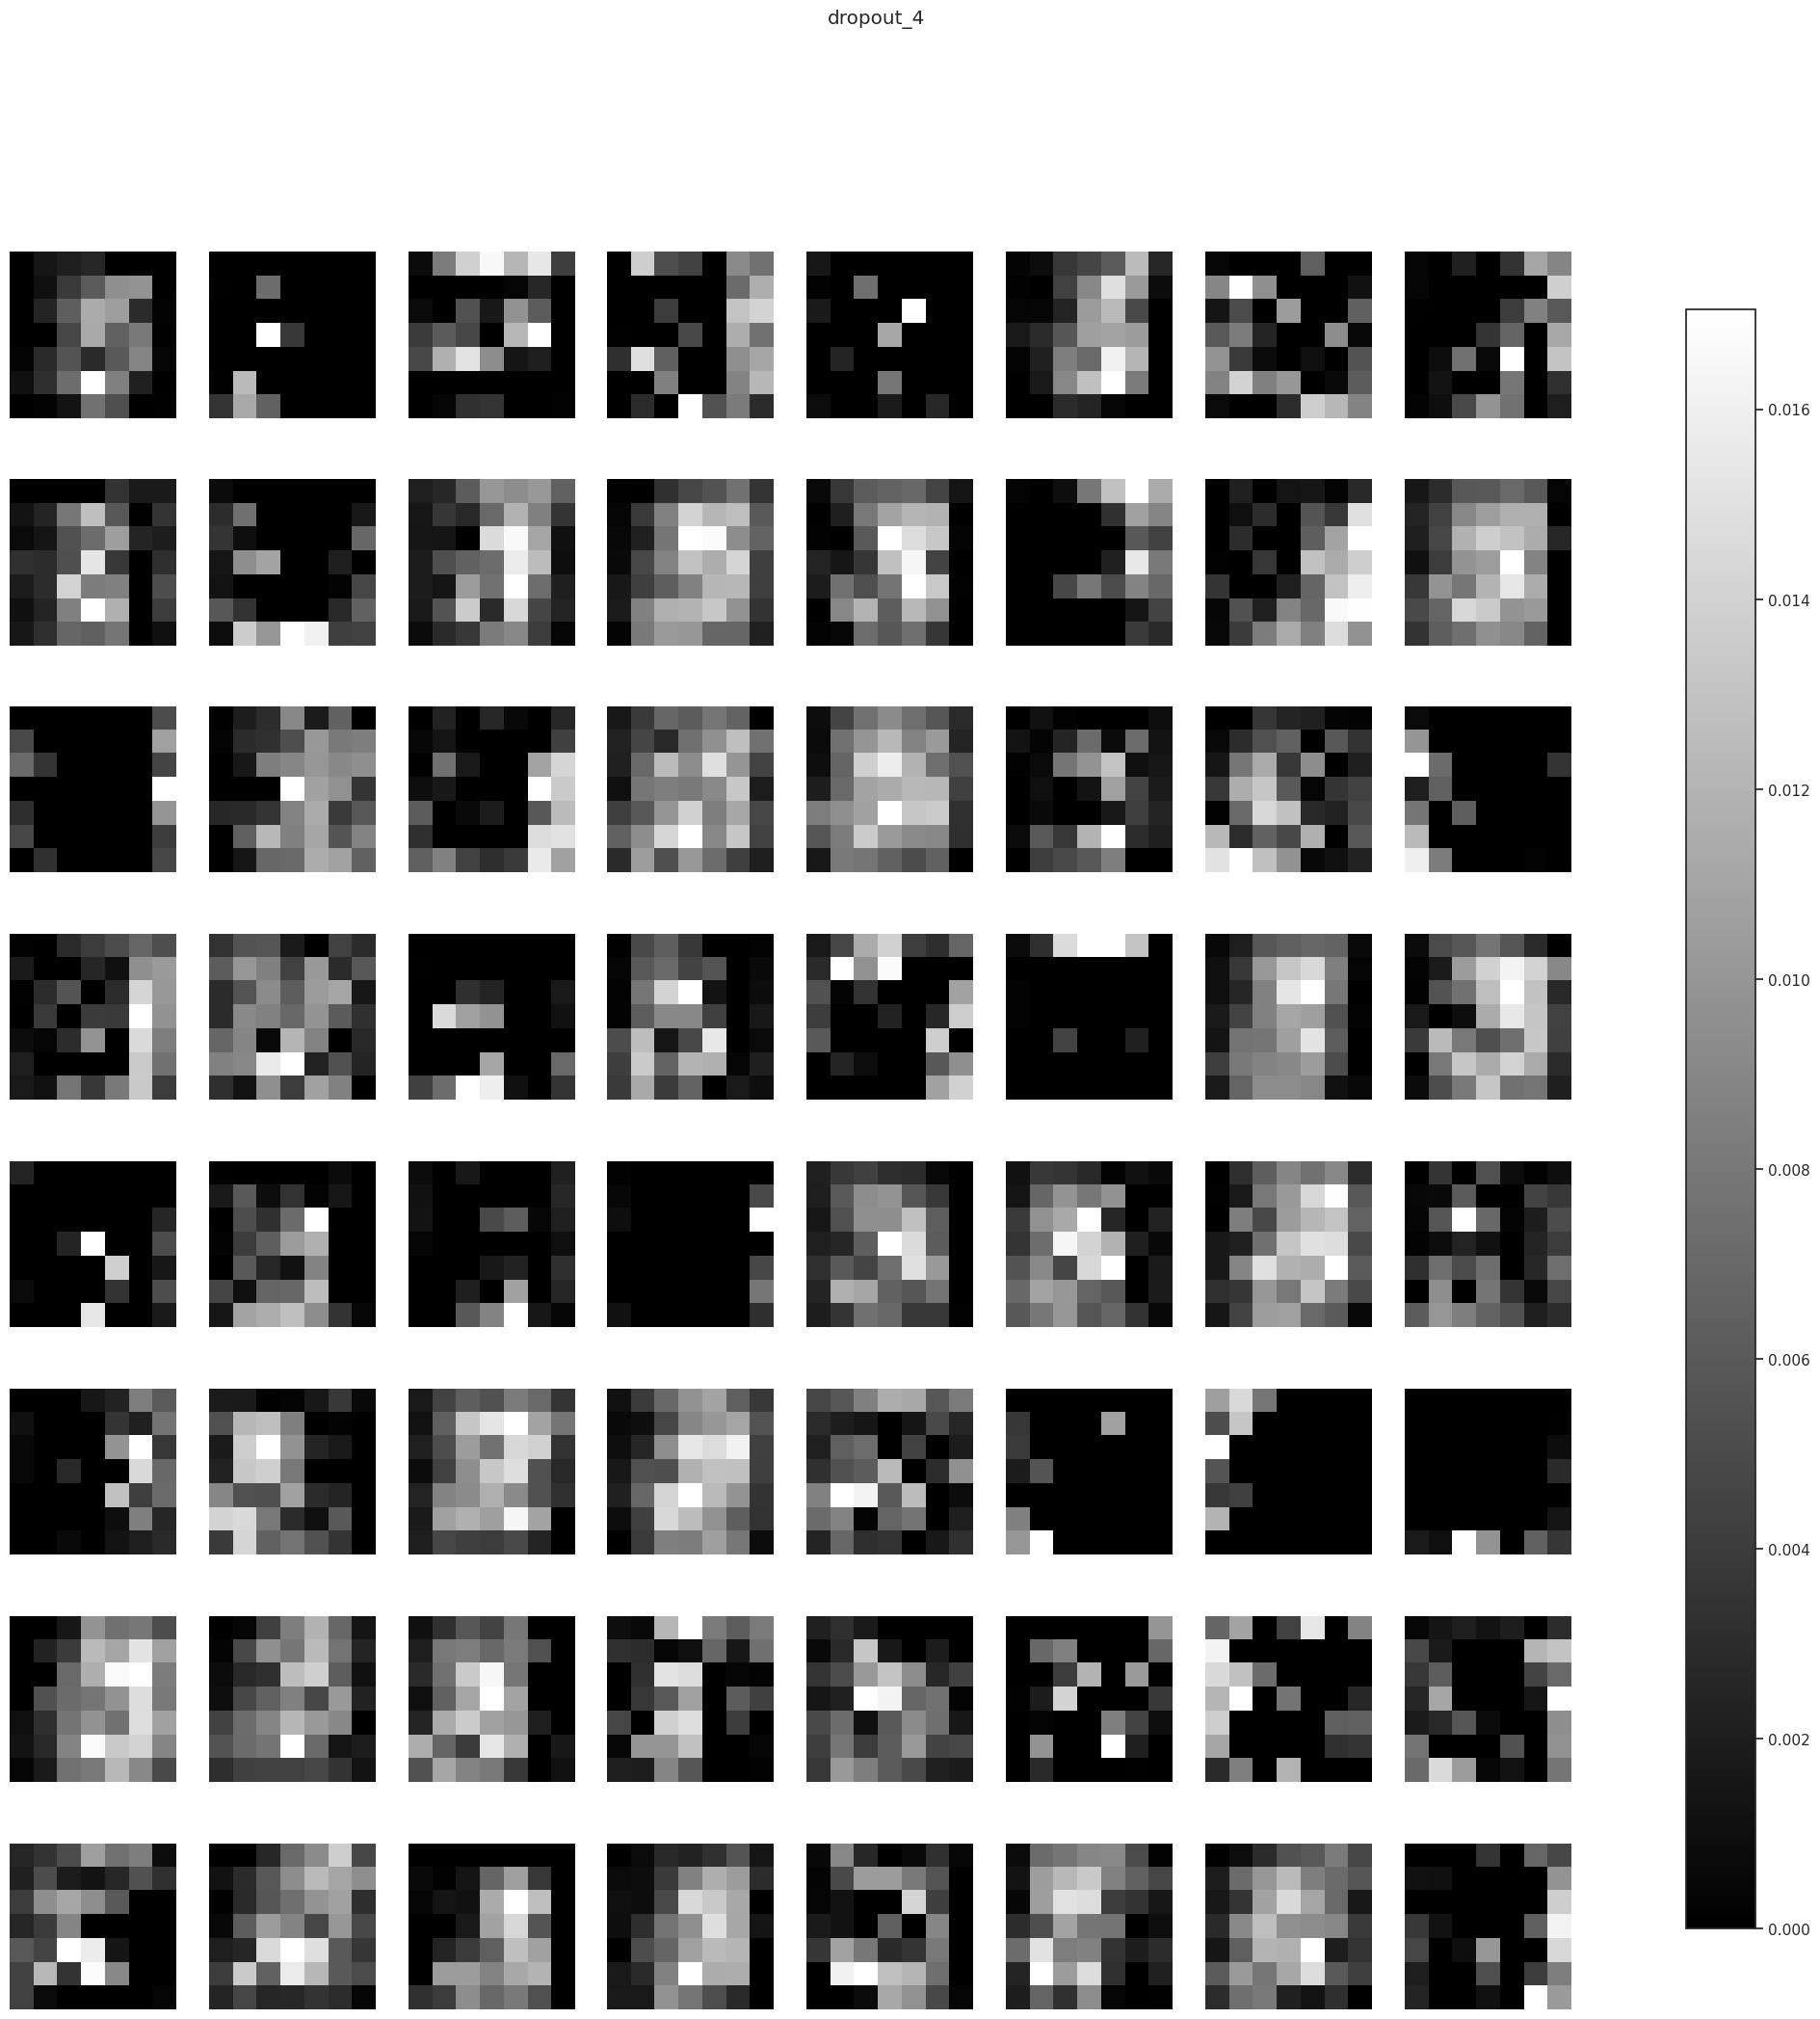

flatten_1 (1, 3136) 


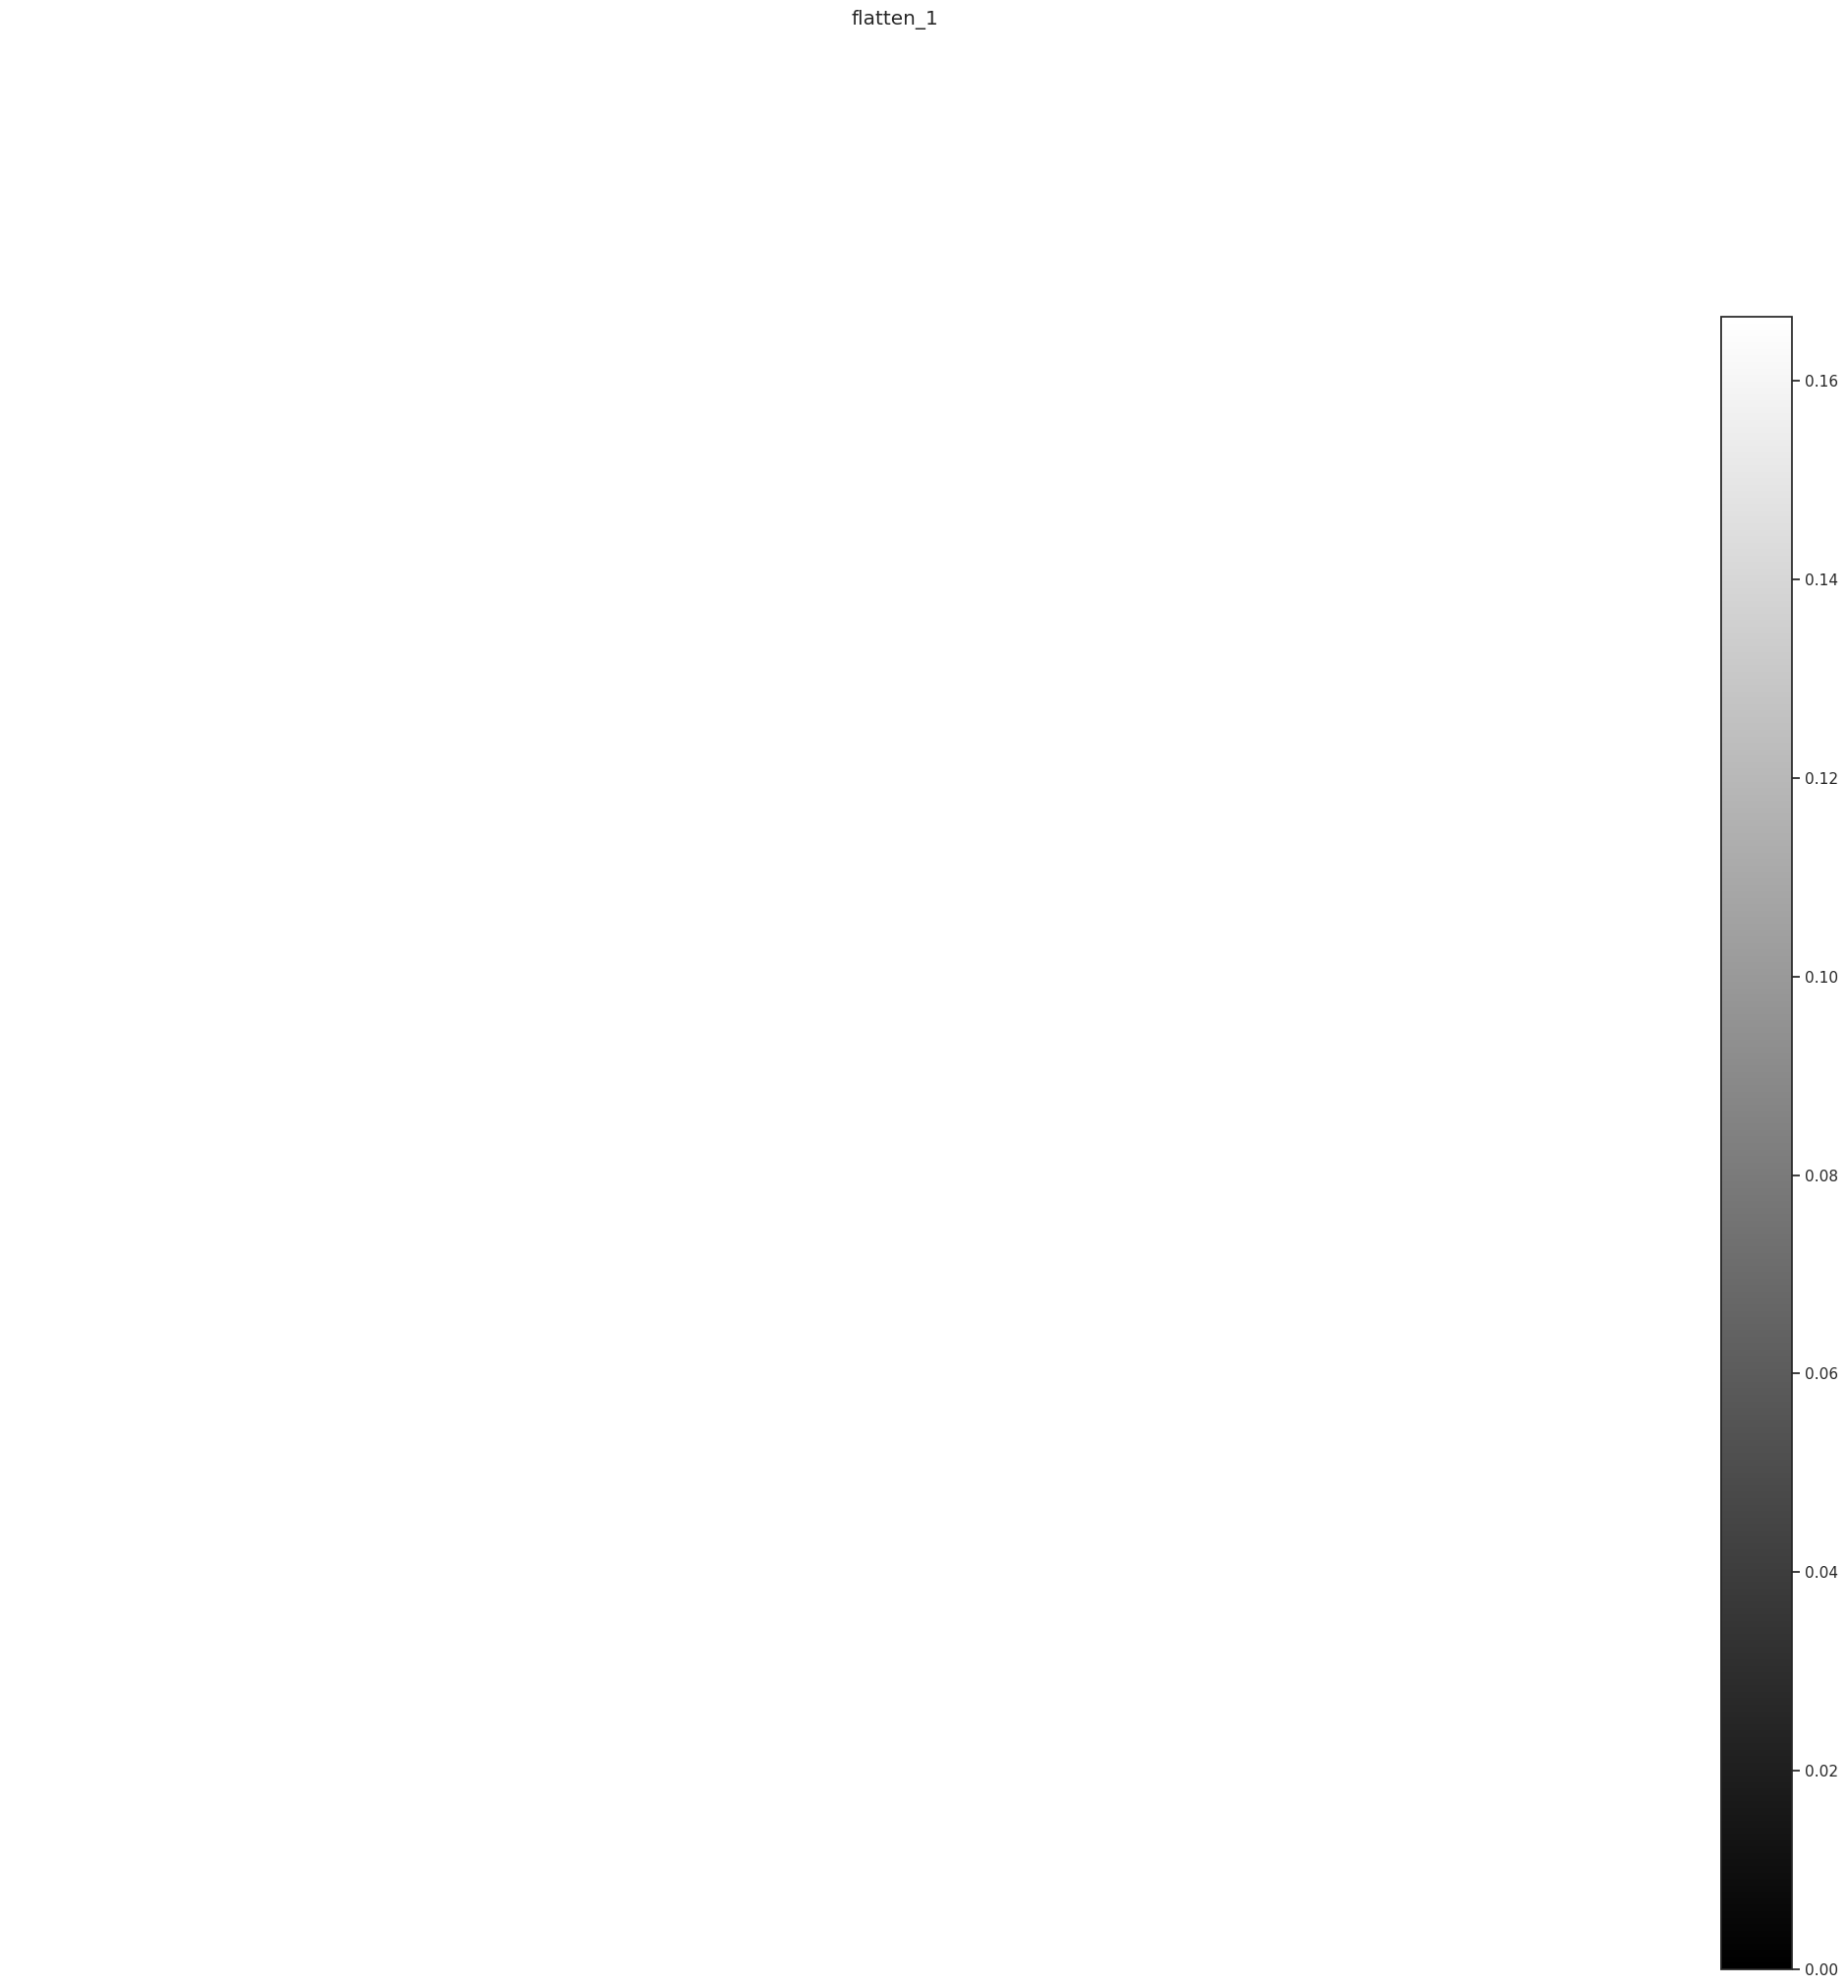

dense_1 (1, 256) 


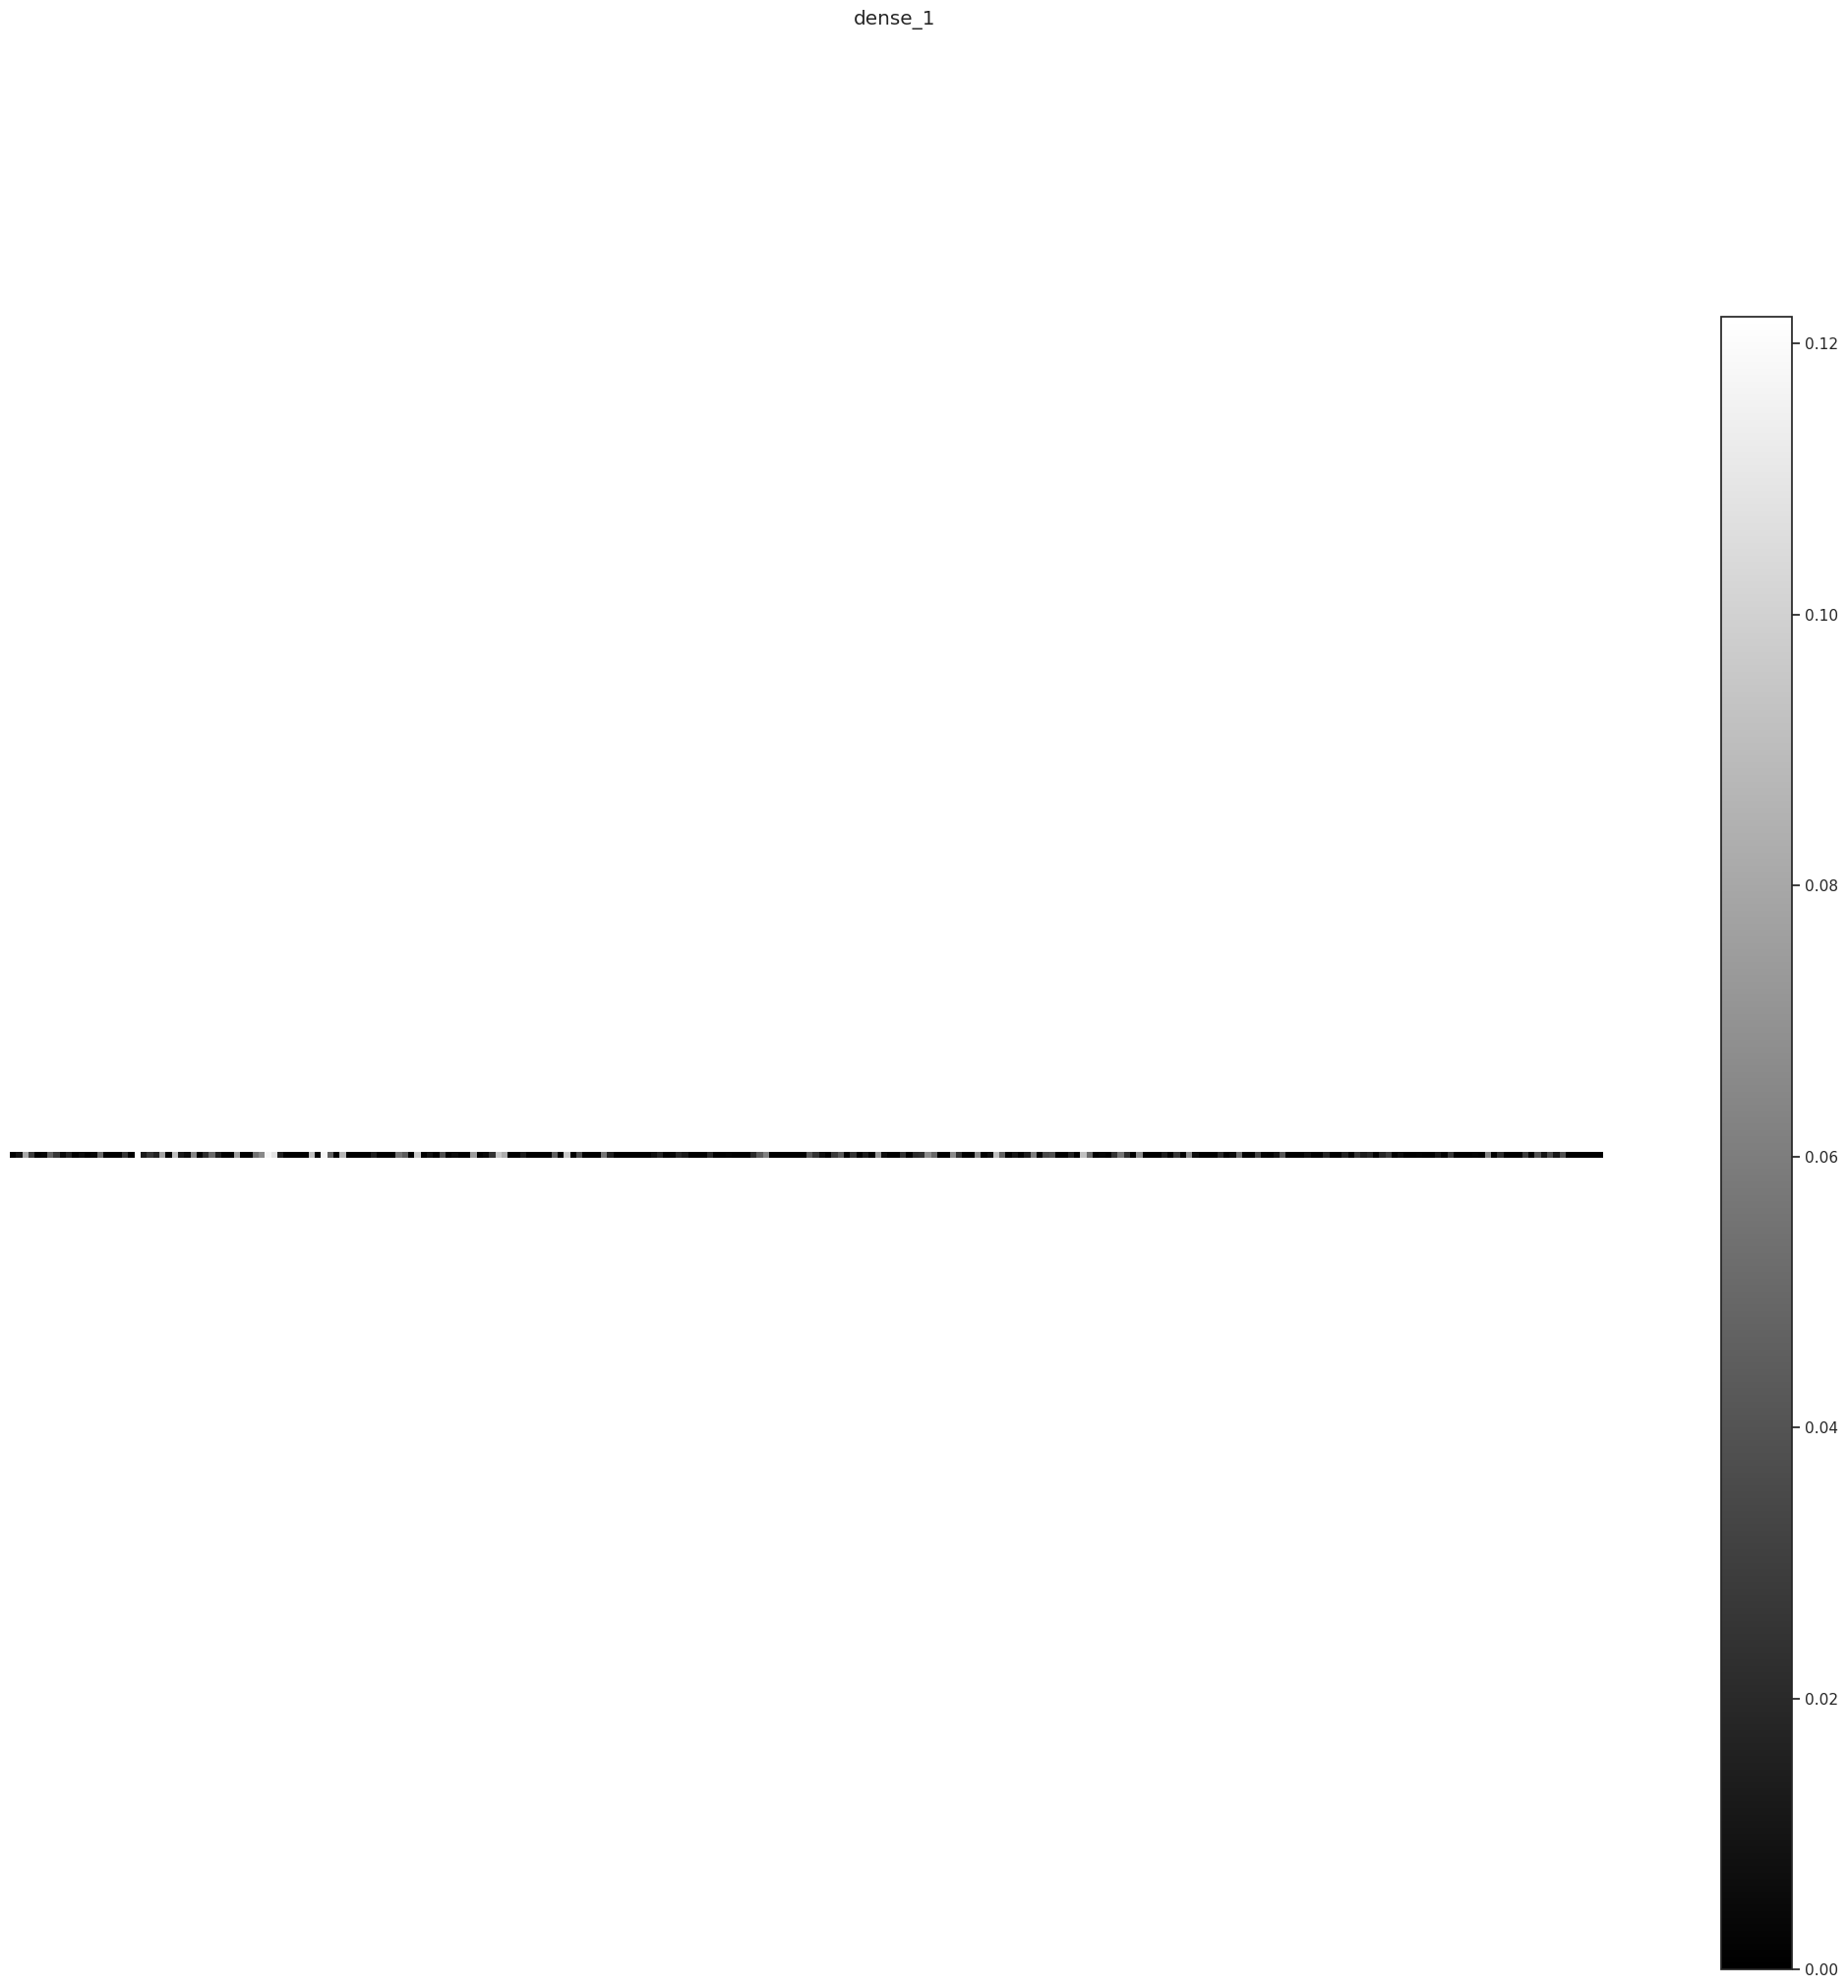

dropout_5 (1, 256) 


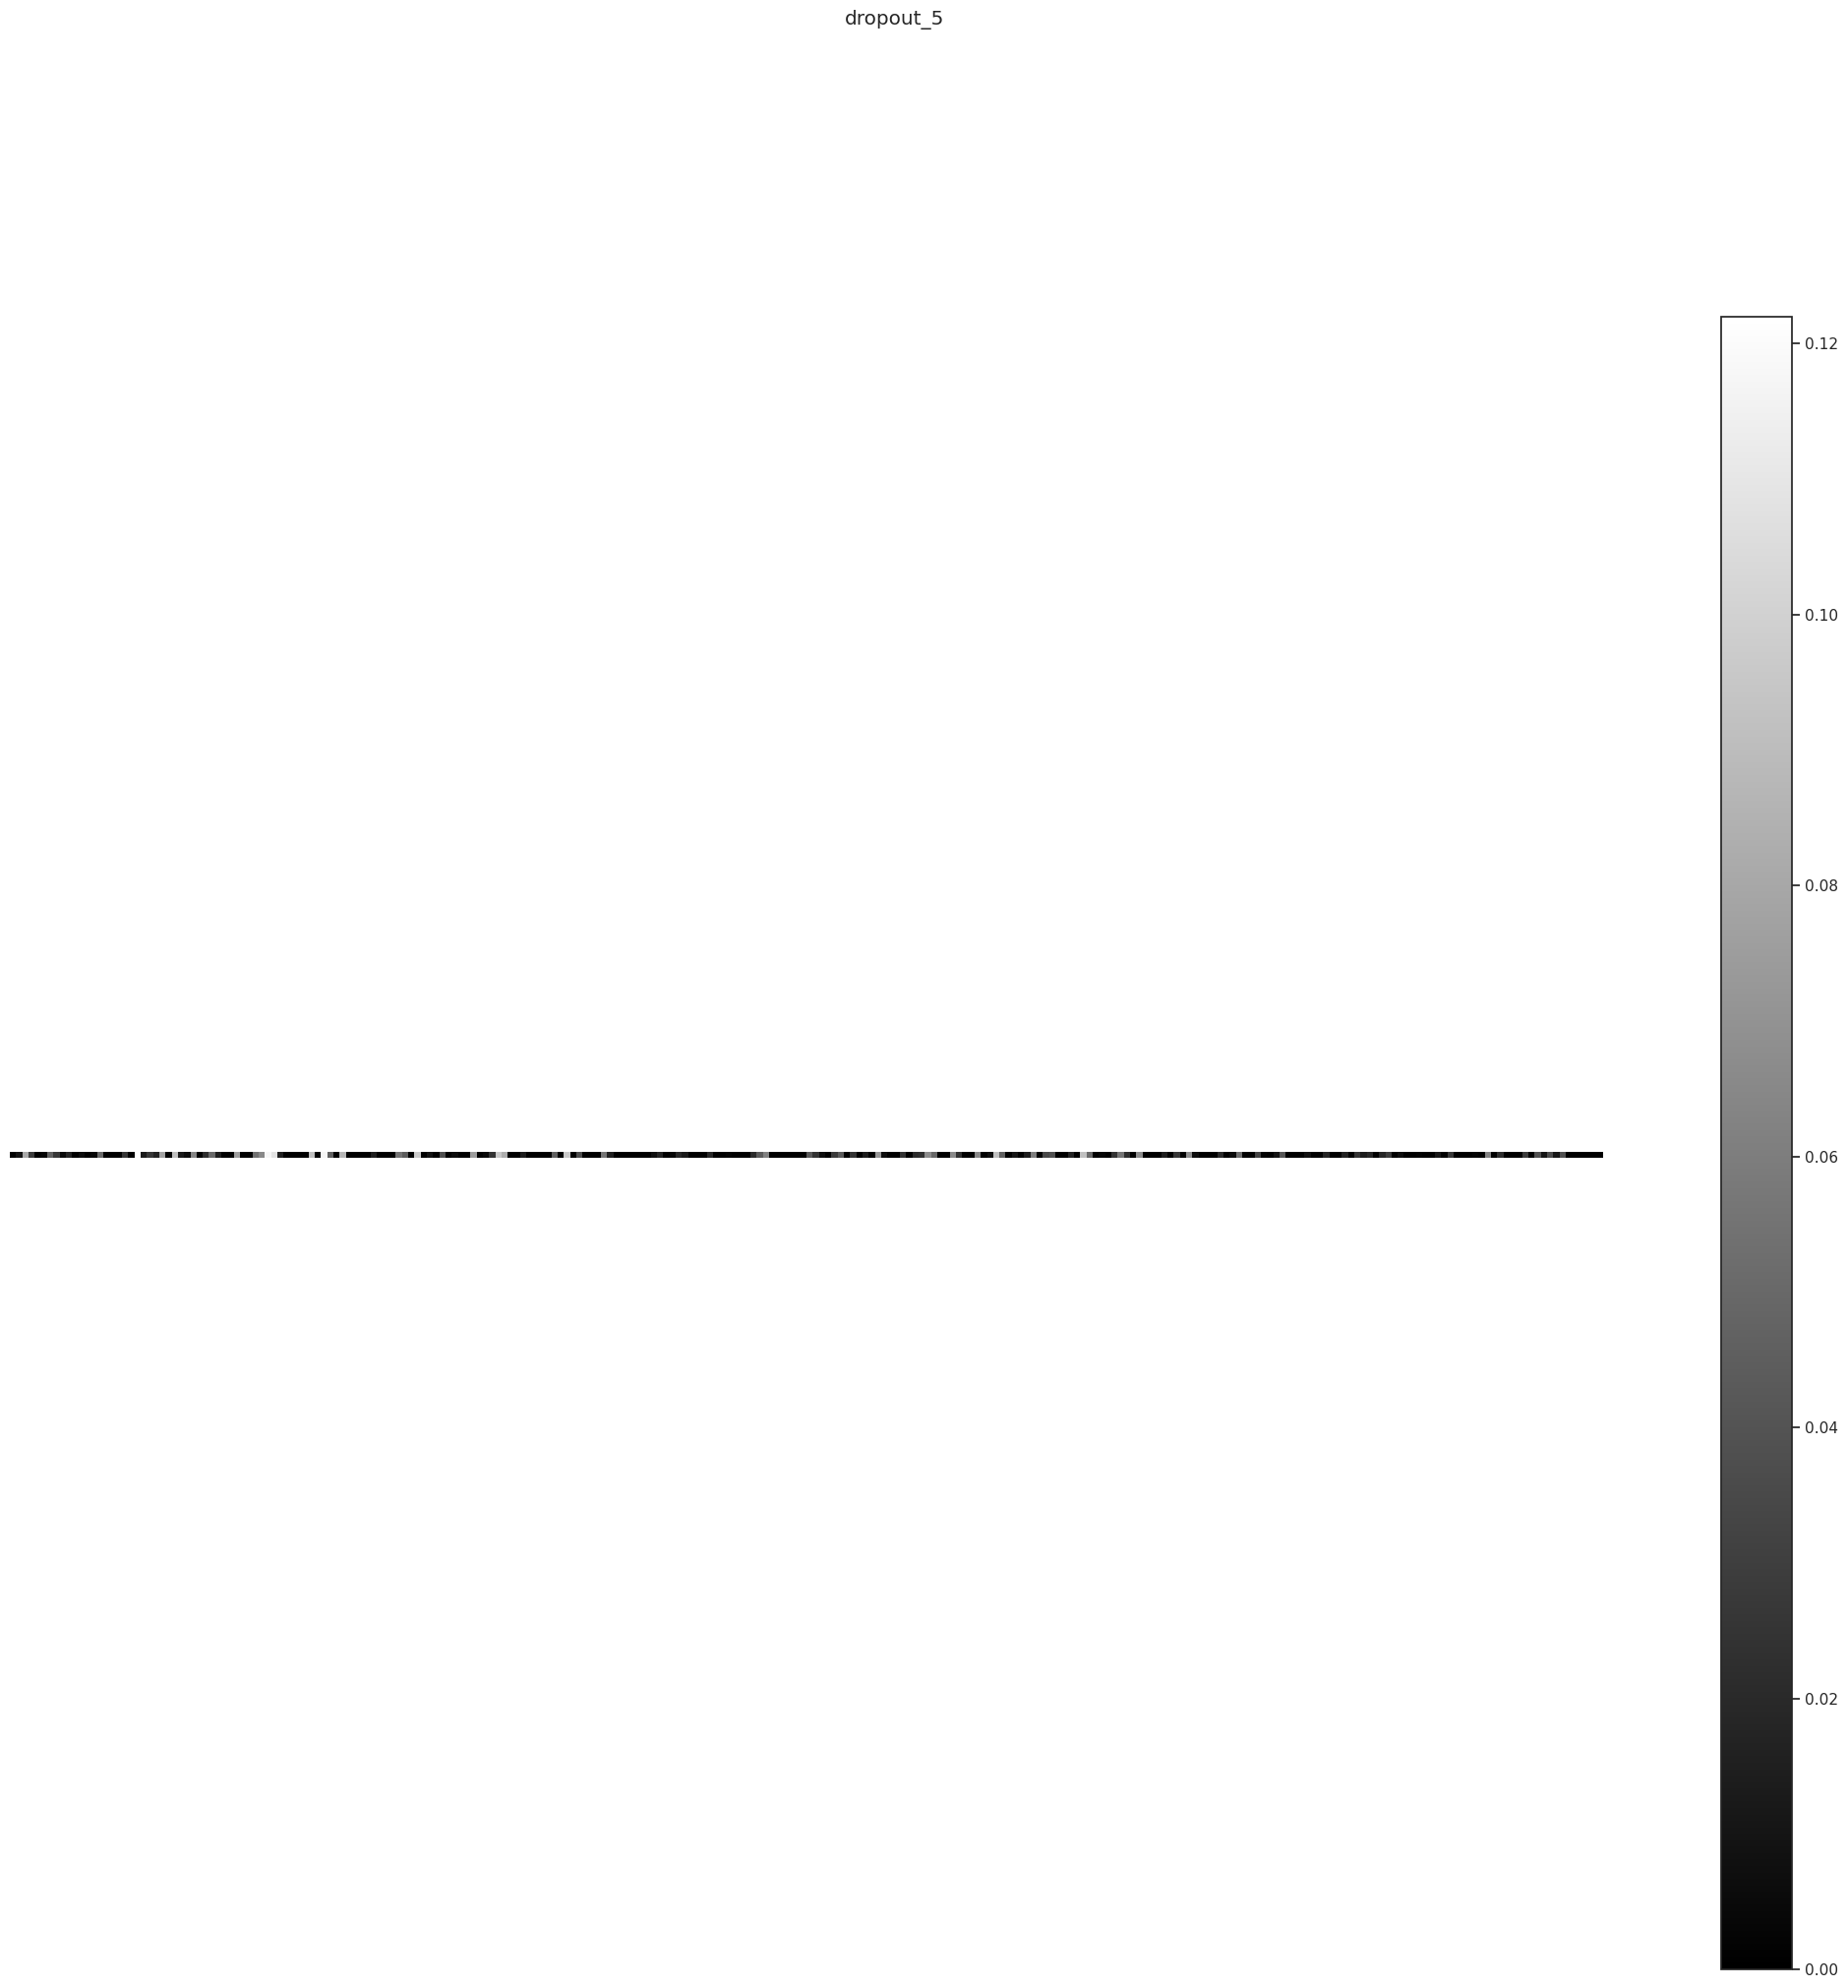

preds (1, 10) 


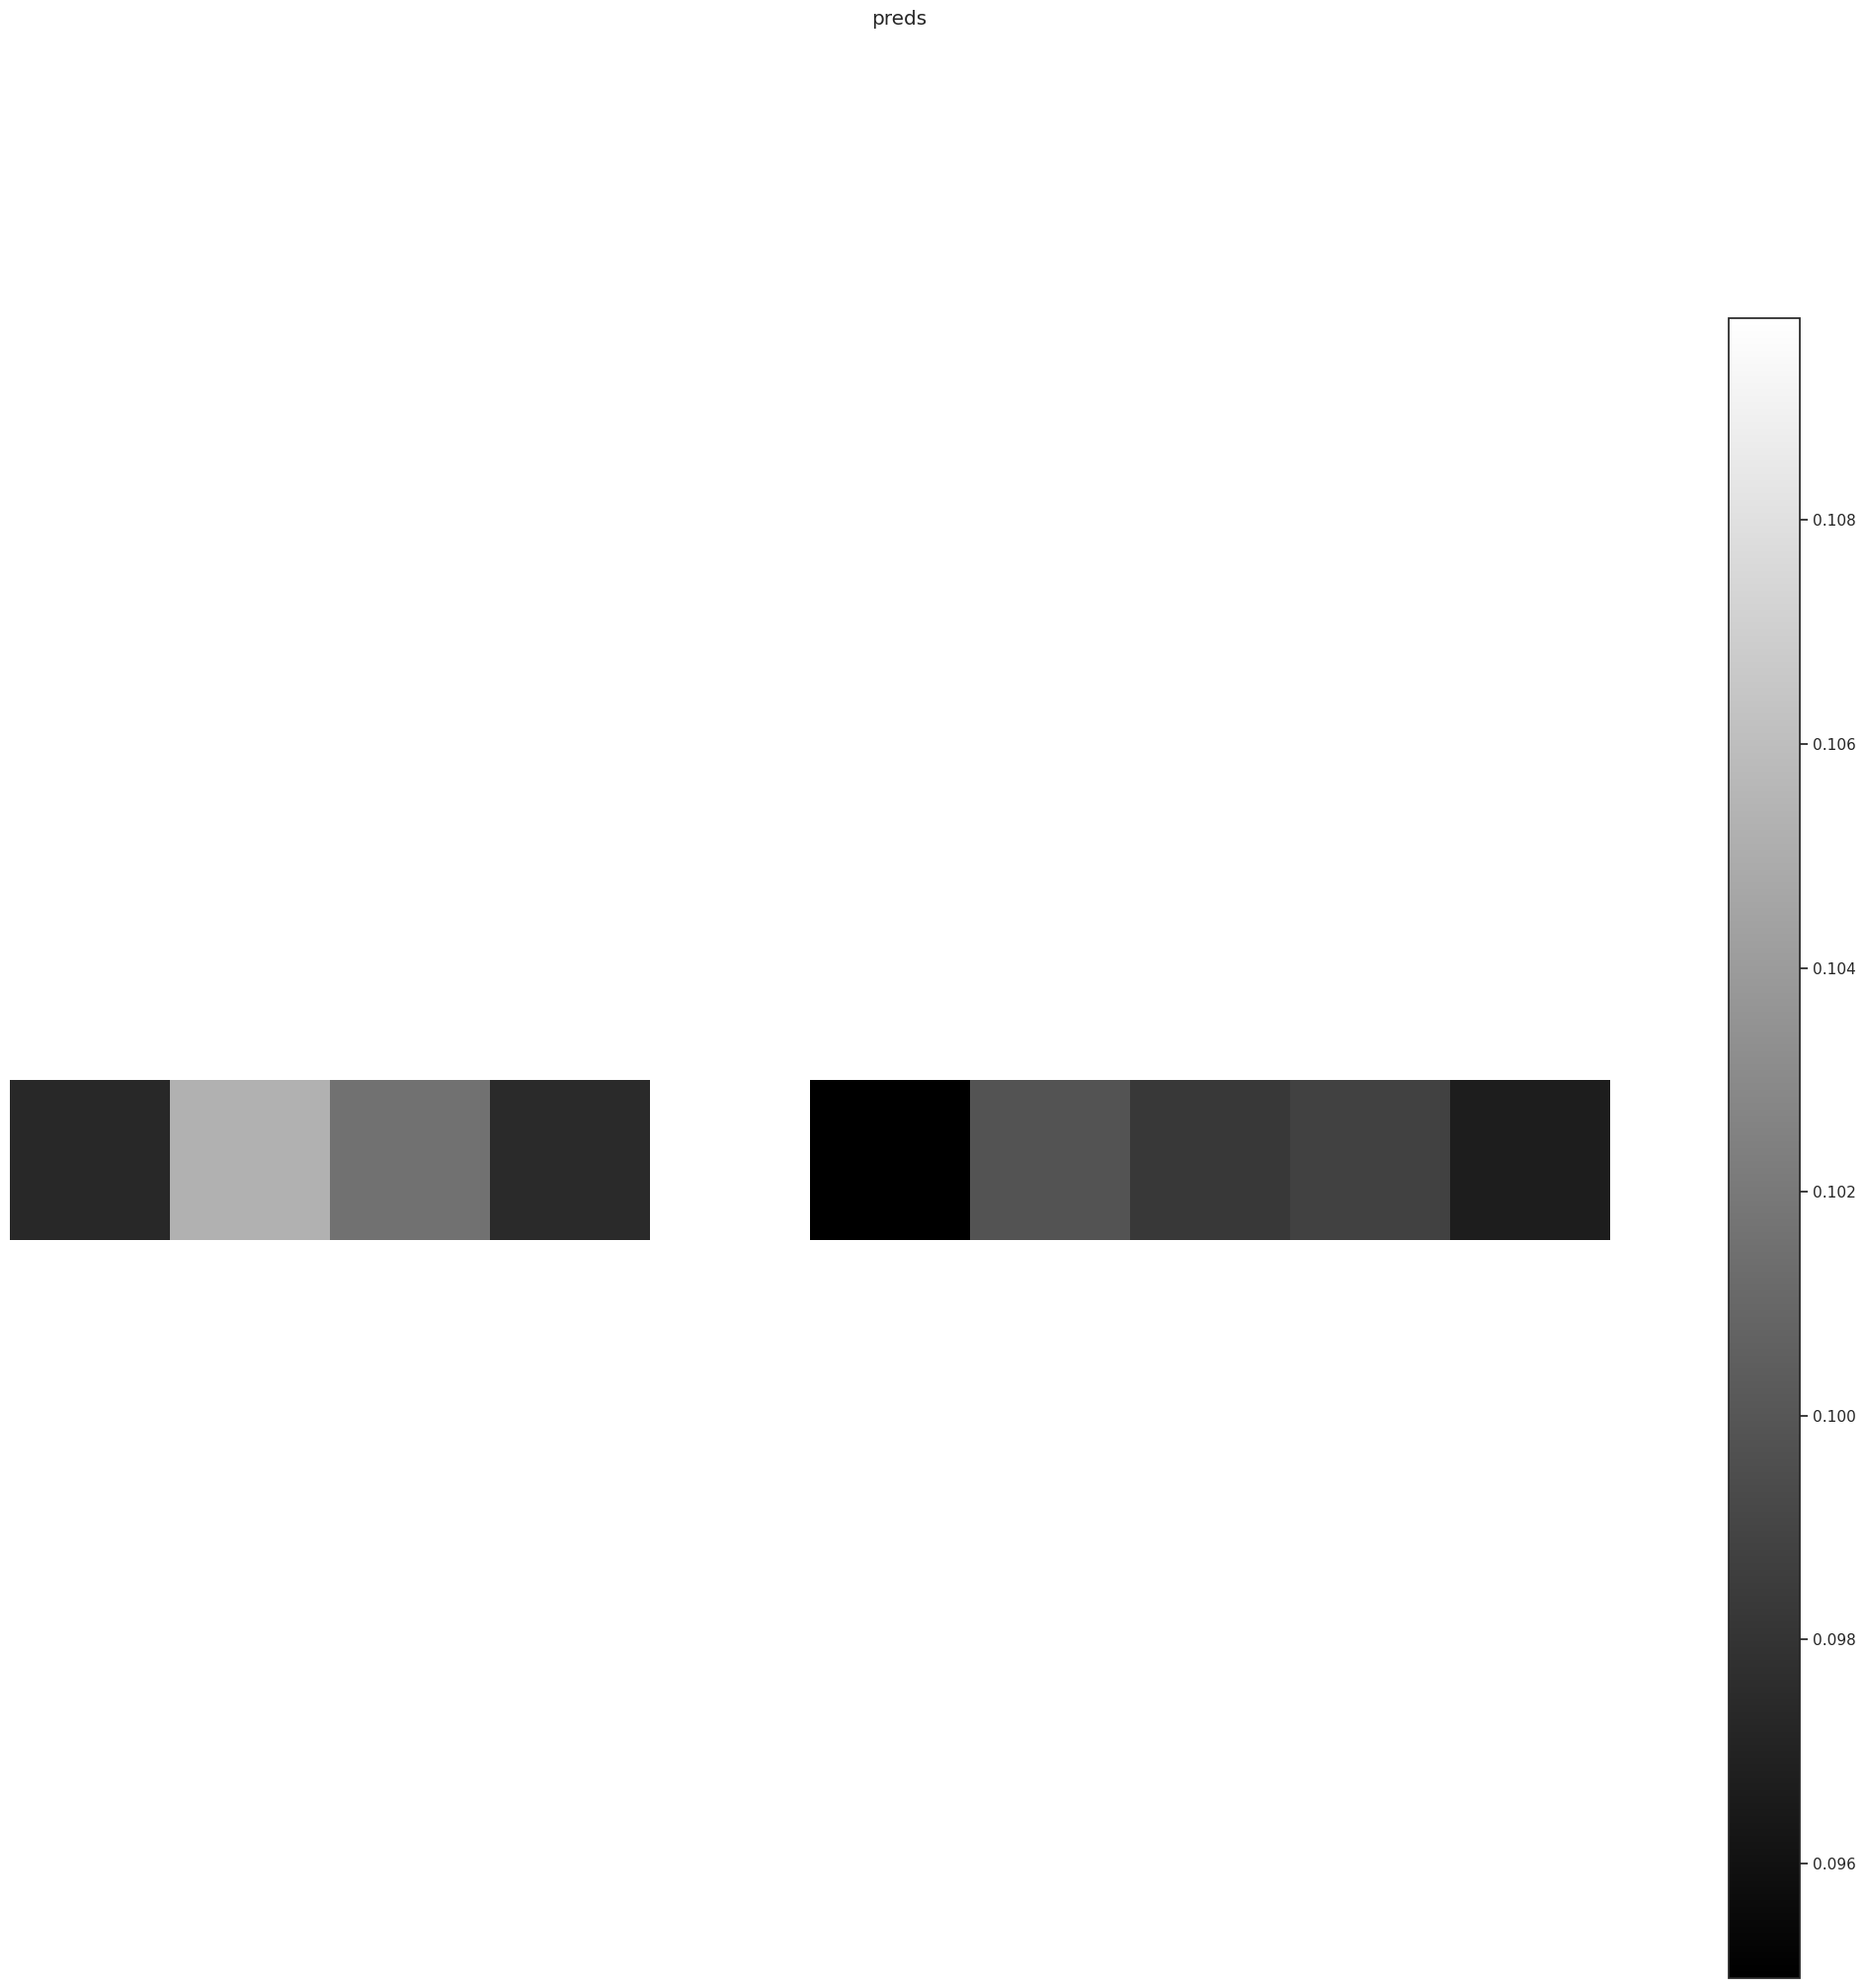

In [32]:
keract_inputs = np.array(X_train[3:4]) # ez egy 3-as szám
print(keract_inputs.shape)

keract_inputs = np.reshape(keract_inputs, (28, 28, 1))
keract_inputs = keract_inputs[np.newaxis, ...]

print(keract_inputs.shape)

activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="gray", save=False)

### Heatmap-ek vizualizálása
A heatmap a neurális hálózat neuron aktivációinak magnitúdója.

conv2d_4_input (1, 28, 28, 1) 


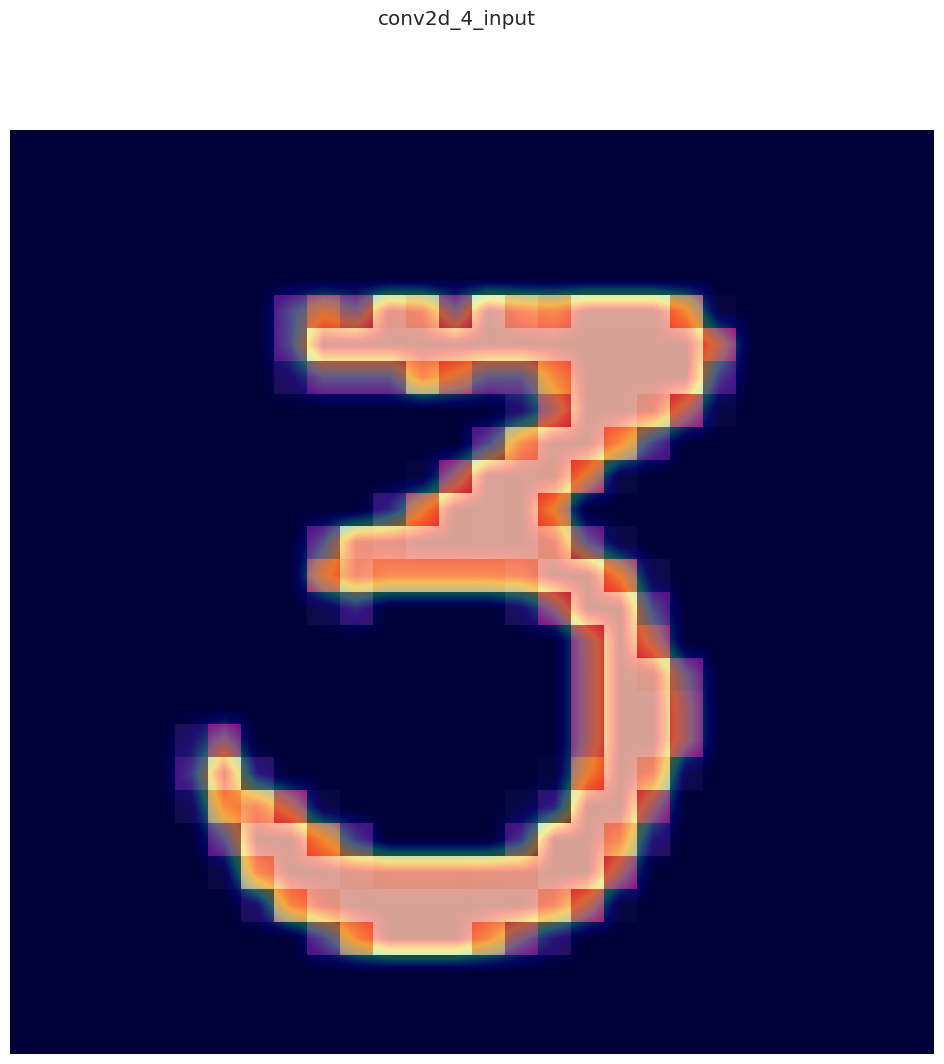

conv2d_4 (1, 28, 28, 32) 


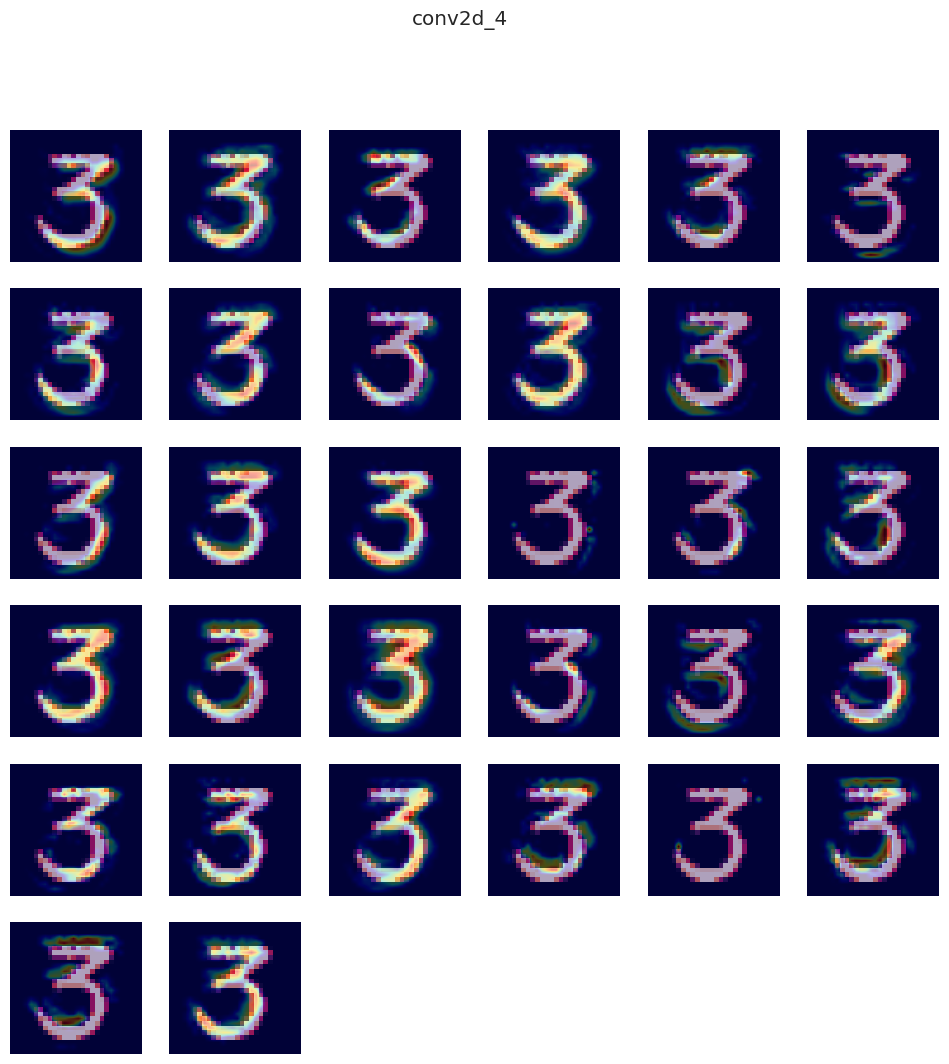

conv2d_5 (1, 28, 28, 32) 


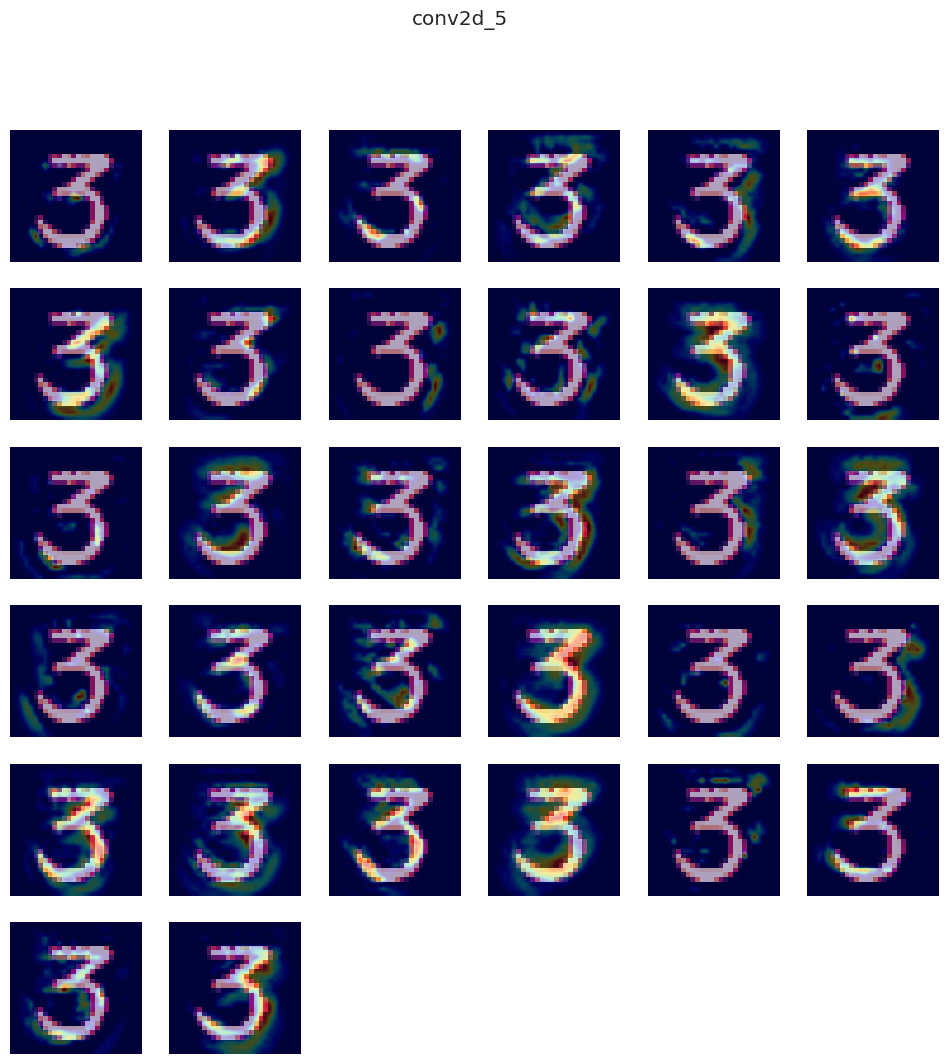

max_pooling2d_2 (1, 14, 14, 32) 


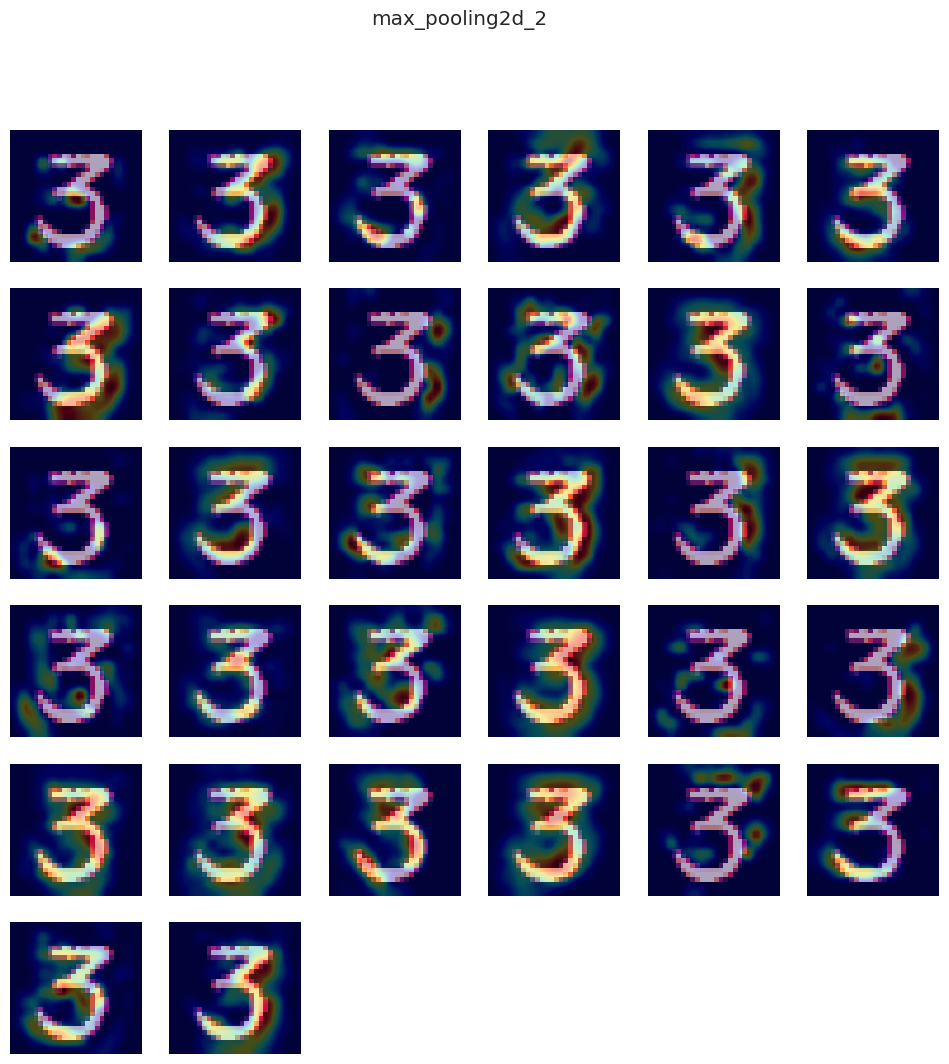

dropout_3 (1, 14, 14, 32) 


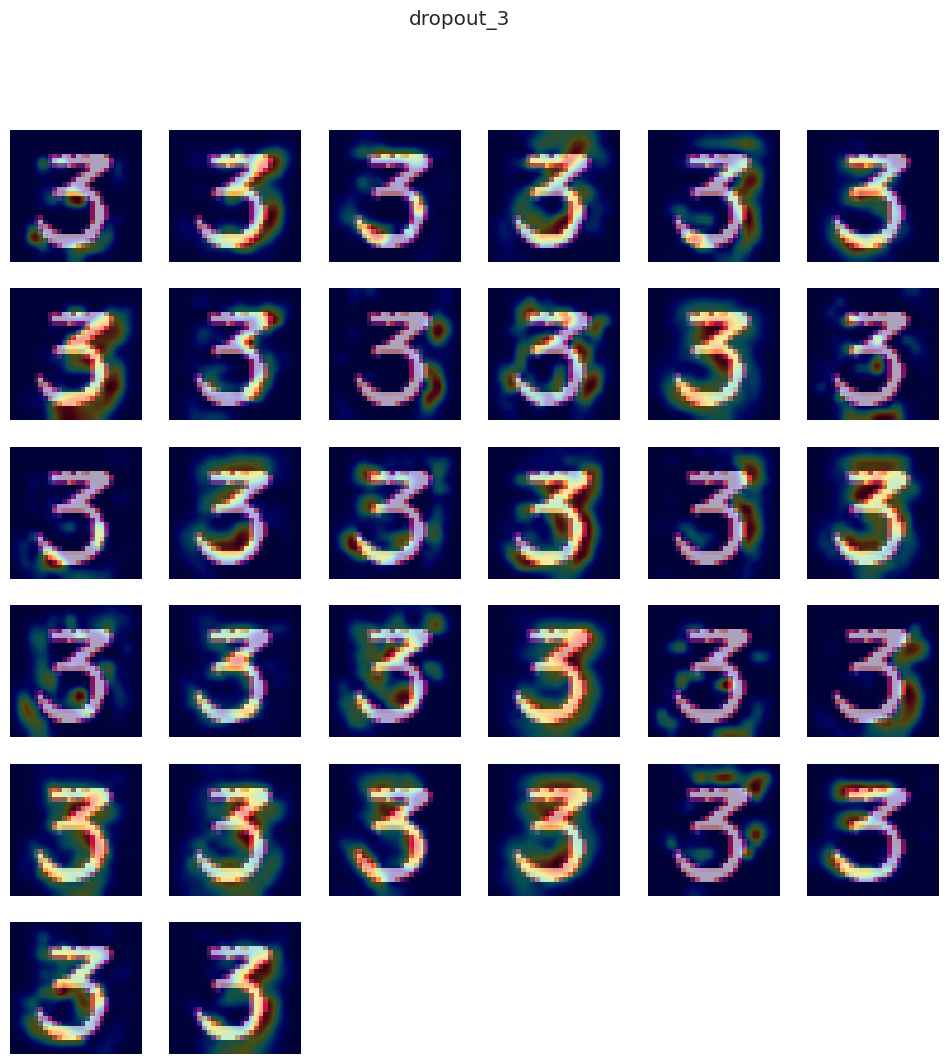

conv2d_6 (1, 14, 14, 64) 


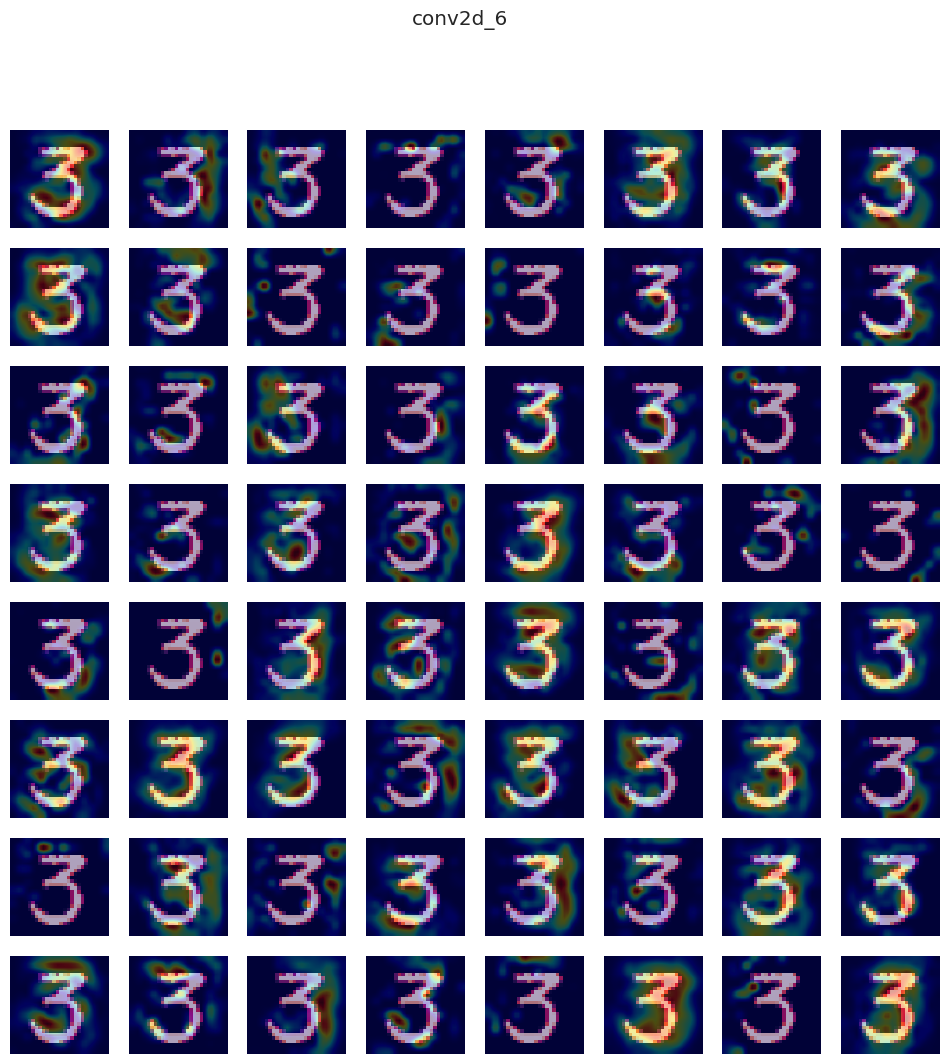

conv2d_7 (1, 14, 14, 64) 


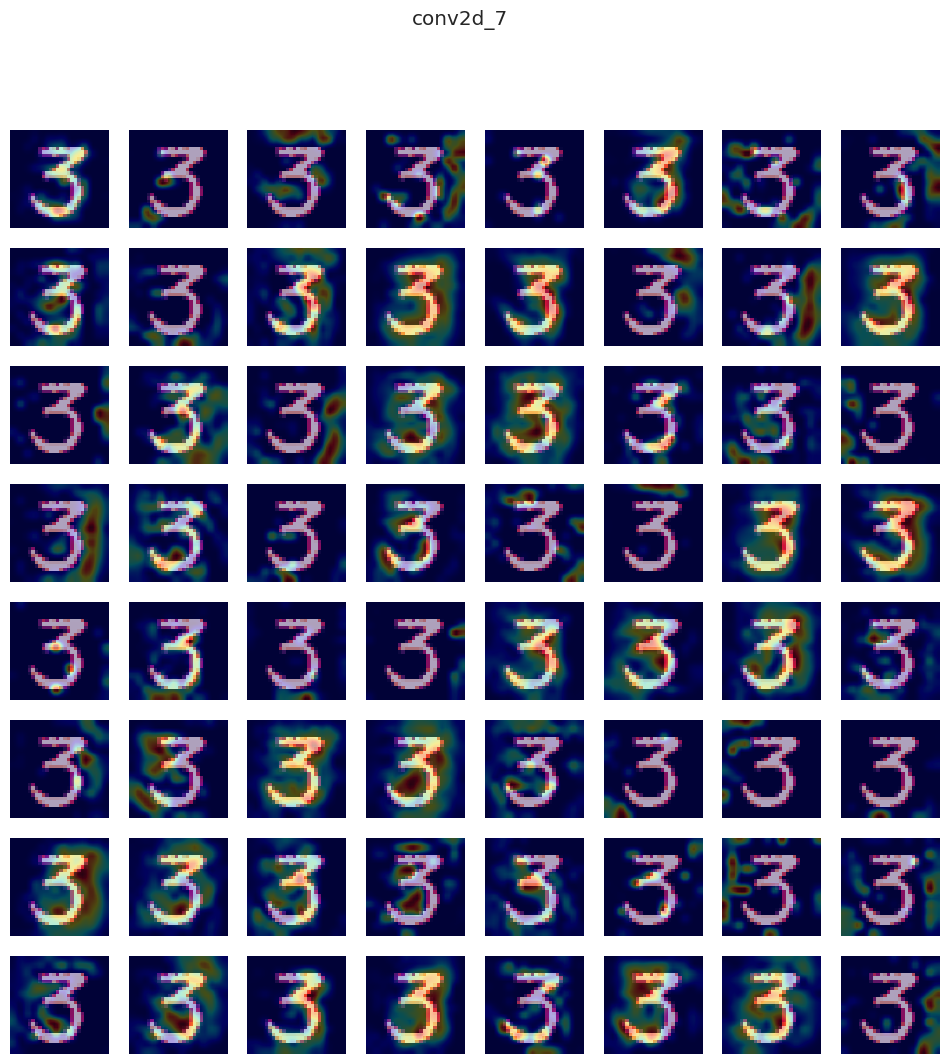

max_pooling2d_3 (1, 7, 7, 64) 


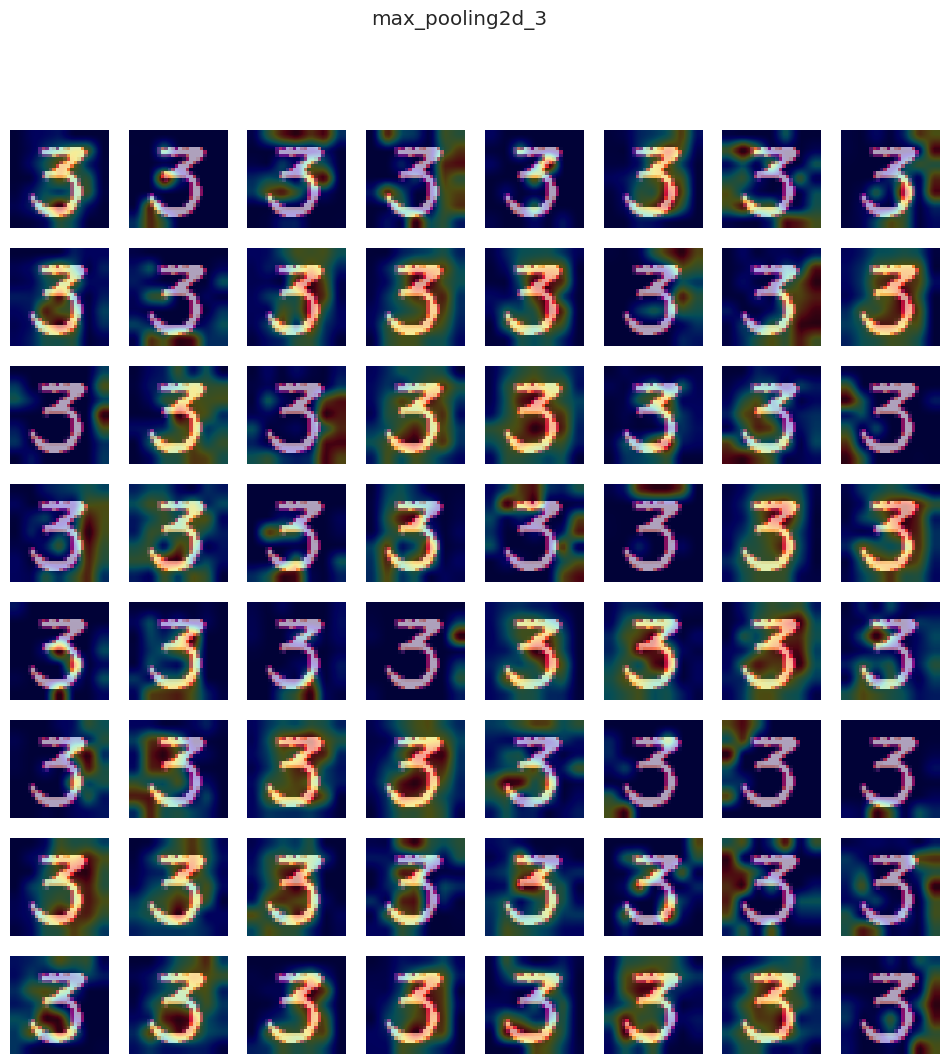

dropout_4 (1, 7, 7, 64) 


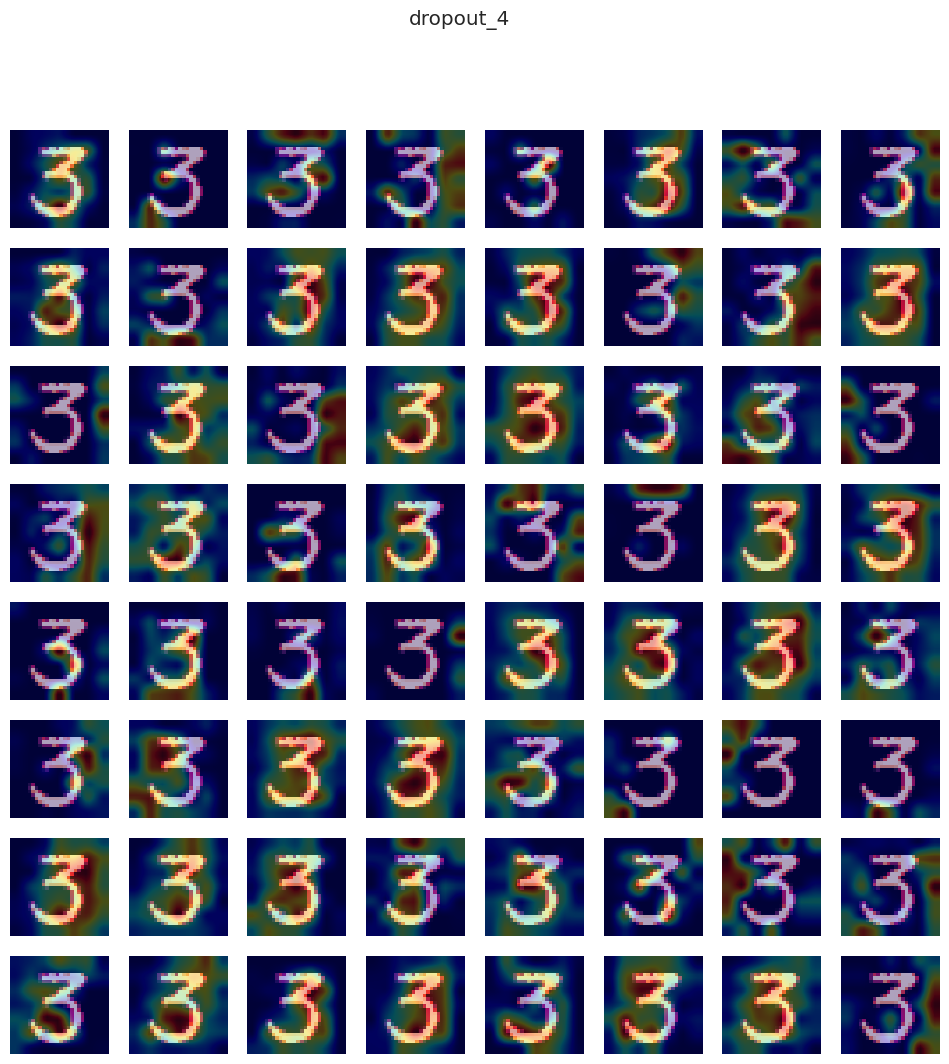

flatten_1 (1, 3136) -> Skipped. 2D Activations.
dense_1 (1, 256) -> Skipped. 2D Activations.
dropout_5 (1, 256) -> Skipped. 2D Activations.
preds (1, 10) -> Skipped. 2D Activations.


In [33]:
display_heatmaps(activations, keract_inputs, directory='.', save=False, fix=True, merge_filters=False)

## Gyorsított tanítási eljárás
Ebben az esetben kihagyjuk az augmentációt, és csak 2000 számon tanítjuk a modellt, 5 epoch-on keresztül.

Figyeljük meg, hogyan zajlik a tanítási eljárás!

In [34]:
history = model.fit(X_train[:2000], Y_train[:2000], batch_size=1000, epochs=5, 
                    validation_data=(X_val[:500], Y_val[:500]), verbose=1)

Train on 2000 samples, validate on 500 samples
Epoch 1/5


2024-01-01 20:47:30.839203: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:507 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/preds_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-01 20:47:30.864291: W tensorflow/c/c_api.cc:305] Operation '{name:'training/RMSprop/preds_1/bias/rms/Assign' id:730 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/preds_1/bias/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/RMSprop/preds_1/bias/rms, training/RMSprop/preds_1/bias/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error i

2000/2000 [==============================] - 1s 526us/sample - loss: 2.2690 - accuracy: 0.1380 - val_loss: 2.1202 - val_accuracy: 0.2800
Epoch 2/5


2024-01-01 20:47:31.844216: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:507 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/preds_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2000/2000 [==============================] - 1s 465us/sample - loss: 2.0471 - accuracy: 0.3160 - val_loss: 1.4696 - val_accuracy: 0.4640
Epoch 3/5
2000/2000 [==============================] - 1s 456us/sample - loss: 1.9519 - accuracy: 0.3570 - val_loss: 2.0699 - val_accuracy: 0.6040
Epoch 4/5
2000/2000 [==============================] - 1s 469us/sample - loss: 1.8182 - accuracy: 0.5825 - val_loss: 1.0241 - val_accuracy: 0.7260
Epoch 5/5
2000/2000 [==============================] - 1s 439us/sample - loss: 1.0330 - accuracy: 0.6645 - val_loss: 1.4596 - val_accuracy: 0.5340


## Modell kiértékelése

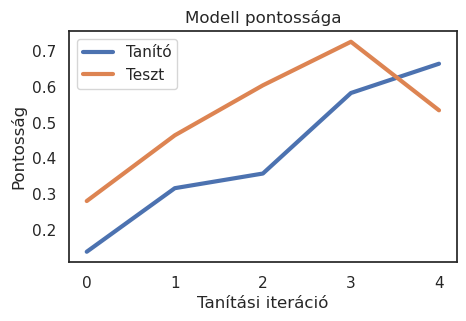

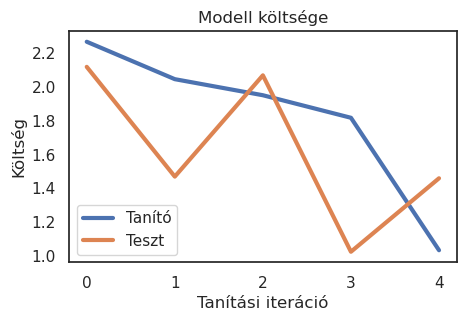

In [41]:
def measure_model(hist):
    # Train és teszt pontosságok
    plt.figure(figsize=(5, 3))
    plt.plot(hist.history['accuracy'], lw=3)
    plt.plot(hist.history['val_accuracy'], lw=3)
    plt.title('Modell pontossága')
    plt.ylabel('Pontosság')
    plt.xlabel('Tanítási iteráció')
    plt.legend(['Tanító', 'Teszt'], loc='upper left')
    plt.show()
    
    
    # Train és teszt költségek 
    plt.figure(figsize=(5, 3))
    plt.plot(hist.history['loss'], lw=3)
    plt.plot(hist.history['val_loss'], lw=3)
    plt.title('Modell költsége')
    plt.ylabel('Költség')
    plt.xlabel('Tanítási iteráció')
    plt.legend(['Tanító', 'Teszt'], loc='lower left')
    plt.show()

measure_model(history)

## Adataugmentálás
Augmentálás során egy ImageDataGenerator objektum jön létre, ami iterálható adatstruktúraként működik.

In [42]:
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False,
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False)
datagen.fit(X_train)

print(datagen)

## Modell tanítása augmentált adatokon
Ez sokáig is tarthat. Érdemes beimportálni az előretanított modellt.

In [44]:
history = model.fit_generator(datagen.flow(X_train, Y_train), 
                              epochs=10,
                              validation_data=(X_val, Y_val), 
                              verbose=1)

# measure_model(history) # Ha valaki lefuttatja ezt, mérje meg a teljesítményt

Epoch 1/10
1182/1182 [==============================] - 21s 17ms/step - batch: 590.5000 - size: 31.9797 - loss: 0.1066 - accuracy: 0.9695 - val_loss: 0.0474 - val_accuracy: 0.9860
Epoch 2/10
1182/1182 [==============================] - 21s 17ms/step - batch: 590.5000 - size: 31.9797 - loss: 0.0904 - accuracy: 0.9742 - val_loss: 0.0487 - val_accuracy: 0.9893
Epoch 3/10
1182/1182 [==============================] - 21s 18ms/step - batch: 590.5000 - size: 31.9797 - loss: 0.0828 - accuracy: 0.9767 - val_loss: 0.0384 - val_accuracy: 0.9907
Epoch 4/10
1182/1182 [==============================] - 24s 20ms/step - batch: 590.5000 - size: 31.9797 - loss: 0.0836 - accuracy: 0.9772 - val_loss: 0.0517 - val_accuracy: 0.9857
Epoch 5/10
1182/1182 [==============================] - 24s 20ms/step - batch: 590.5000 - size: 31.9797 - loss: 0.0841 - accuracy: 0.9774 - val_loss: 0.0309 - val_accuracy: 0.9907
Epoch 6/10
1182/1182 [==============================] - 24s 20ms/step - batch: 590.5000 - size: 31.9

## Modell betöltése / elmentése
Mivel a tanítás több órát is igénybe vehet, töltsük be a modellt egy fájlból.

Próbáljuk meg ismételten lefuttatni a rétegek vizualizálását, a már betöltött modellen! Milyen különbséget figyelhetünk meg?

In [45]:
model = load_model('digit_model.h5')

# model.save('digit_model.h5')

print(model)

2024-01-01 20:54:33.059655: W tensorflow/c/c_api.cc:305] Operation '{name:'preds_2/kernel/Assign' id:1140 op device:{requested: '', assigned: ''} def:{{{node preds_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](preds_2/kernel, preds_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-01 20:54:33.212561: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2/kernel/rms/Assign' id:1353 op device:{requested: '', assigned: ''} def:{{{node dense_2/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/kernel/rms, dense_2/kernel/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no ef

## Predikció a teszt adatokon

In [46]:
Y_pred = model.predict(X_val)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Y_val,axis = 1)

display(pd.DataFrame(Y_pred[:10]))

display(Y_pred_classes[:10])

2024-01-01 20:54:52.651888: W tensorflow/c/c_api.cc:305] Operation '{name:'preds_2/Softmax' id:1151 op device:{requested: '', assigned: ''} def:{{{node preds_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](preds_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


0             1             2             3             4  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  1.063870e-27  3.117200e-30  4.907304e-06   
2  0.000000e+00  0.000000e+00  0.000000e+00  1.005591e-26  0.000000e+00   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.517175e-31   
5  4.096445e-35  2.449461e-35  1.000000e+00  1.161653e-17  1.861582e-36   
6  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
7  1.182248e-24  2.818437e-28  6.442623e-10  9.999990e-01  1.138971e-24   
8  0.000000e+00  0.000000e+00  2.652972e-24  7.685179e-26  1.907255e-29   
9  1.000000e+00  0.000000e+00  1.801888e-26  0.000000e+00  0.000000e+00   

              5             6             7             8             9  
0  0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
1  4.042821e-27  0.000000e+00  3.345760e-15  2.048019e-13  9.999951e-01  
2  1.000000e+00  1.960567e-37  0.000000e+00  1.686411e-29  7.652817e-35  
3  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00  2.401652e-36  
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
5  0.000000e+00  0.000000e+00  5.634054e-21  1.215875e-18  5.875163e-36  
6  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
7  7.933120e-10  1.335167e-25  5.910479e-11  9.240904e-07  2.176403e-18  
8  4.397724e-37  0.000000e+00  1.000000e+00  2.639985e-28  1.175517e-17  
9  0.000000e+00  1.099896e-28  0.000000e+00  6.151892e-33  2.387707e-33

array([6, 9, 5, 7, 9, 2, 3, 3, 7, 0])

## Konfúziós mátrix

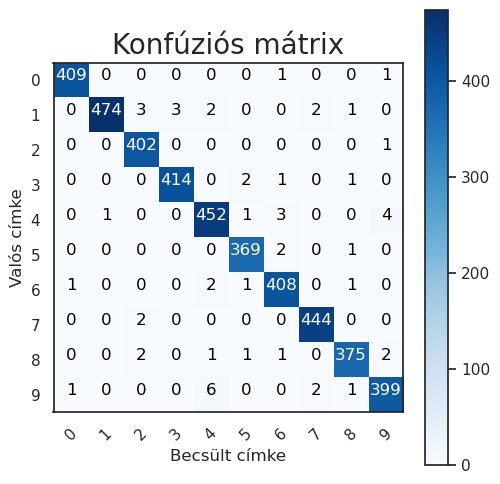

In [51]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Konfúziós mátrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('Valós címke')
    plt.xlabel('Becsült címke')

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(10))

## Normalizált konfúziós mátrix
A normalizálással látni fogjuk a modell relatív hibáit. Mi látható rajta? Melyik számot keverte össze melyikkel?


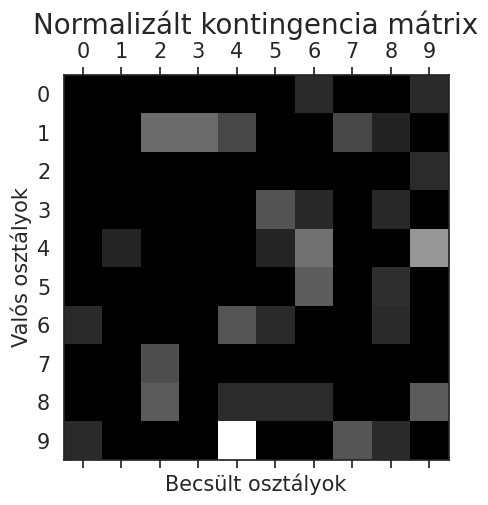

In [53]:
row_sums = confusion_mtx.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_mtx / row_sums

np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize=(5, 5))
plt.title("Normalizált kontingencia mátrix", size=20)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=0)
plt.ylabel('Valós osztályok', size=15)
plt.xlabel('Becsült osztályok', size=15)
plt.xticks(np.arange(10), size=15)
plt.yticks(np.arange(10), size=15)
plt.show()

## Próbáljuk meg csak 4, 9 számokat kirajzolni
Amit láthatunk, egy különleges kontingencia tábla, amiben a négyeseket és kilenceseket veti össze a modell. 

Ezek személyre szabhatók! Próbáljuk meg a normalizált konfúziós mátrix alapján saját számokkal futtatni.

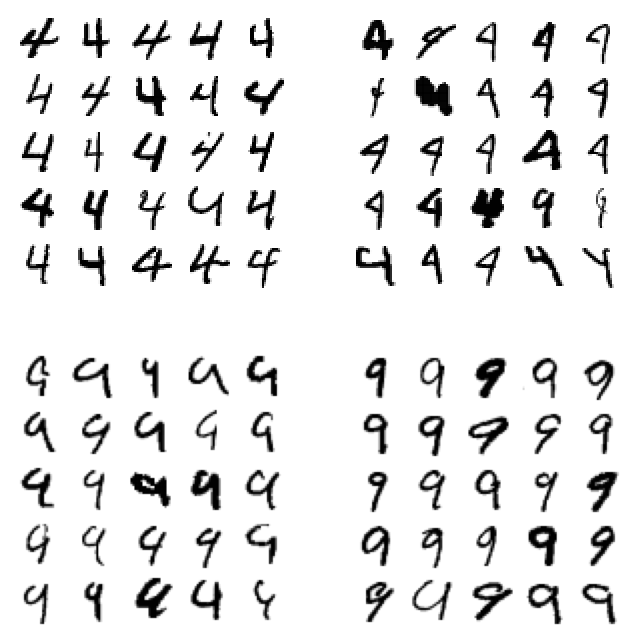

In [54]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Y_train_reverted = np.argmax(Y_train, axis=1)
Y_train_pred = model.predict(X_train)
Y_train_pred_reverted = np.argmax(Y_train_pred, axis=1)

cl_a, cl_b = 4, 9
X_aa = X_train[(Y_train_reverted==cl_a) & (Y_train_pred_reverted==cl_a)]
X_ab = X_train[(Y_train_reverted==cl_a) & (Y_train_pred_reverted==cl_b)]
X_ba = X_train[(Y_train_reverted==cl_b) & (Y_train_pred_reverted==cl_a)]
X_bb = X_train[(Y_train_reverted==cl_b) & (Y_train_pred_reverted==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## A hibás kimenetek megjelenítése
Próbáljuk meg a legnagyobb hibával rendelkező egyedeket kirakni a képernyőre. 

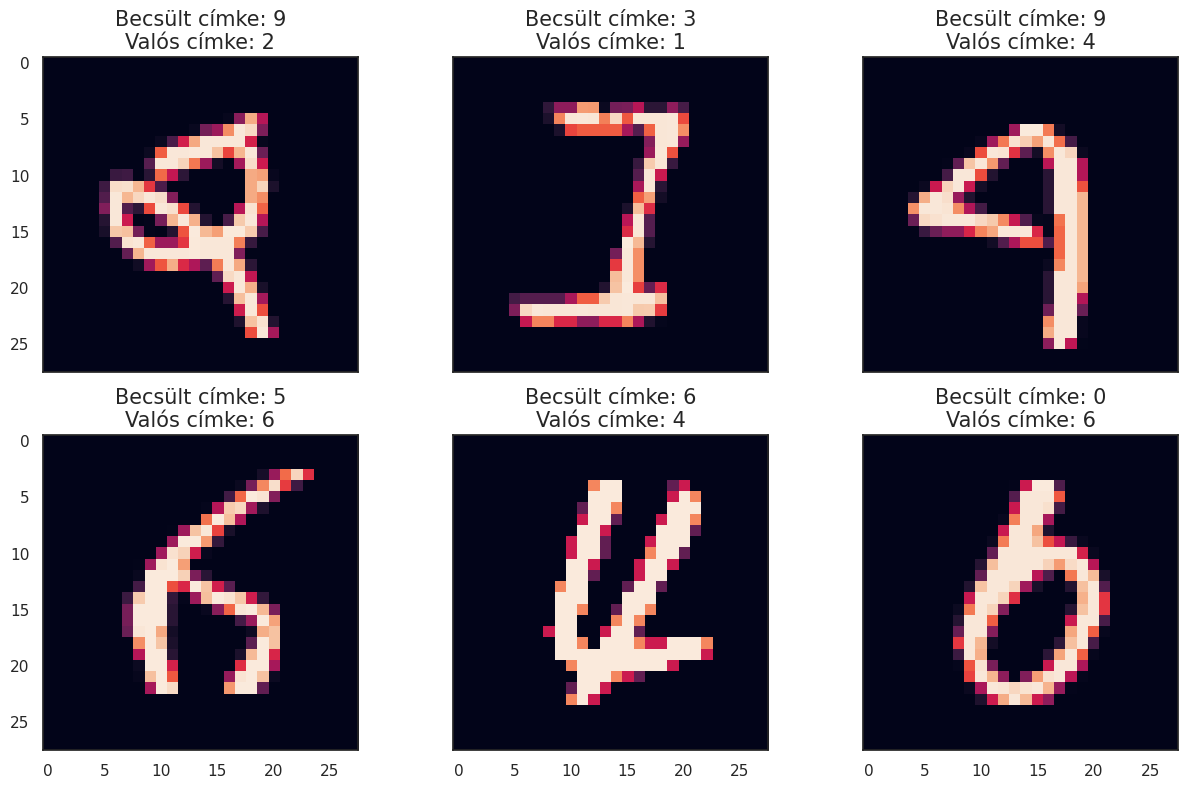

In [55]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows, ncols = 2, 3
    fig, ax = plt.subplots(2, 3, sharex=True,sharey=True, figsize=(15,9))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Becsült címke: {}\nValós címke: {}".format(pred_errors[error],
                                                                               obs_errors[error]), size=15)
            n += 1

# Rossz predikciók valószínűsége
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Becsült valószínűsége az igazi értékeknek a hibás adathalmazon 
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# A becsült és valós értékek közötti különbség
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Rendezett lista a különbségekről
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 hibás adat
most_important_errors = sorted_dela_errors[-6:]

# Top 6 hibás adat kirajzolása
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Predikció a validációs adatokon

In [56]:
results_pred = model.predict(test)

results = np.argmax(results_pred, axis = 1)

results = pd.Series(results, name="Label")

display(pd.DataFrame(results_pred[:10]))
print()
display(results[:10])

0             1             2             3             4  \
0  3.399235e-35  3.235635e-37  1.000000e+00  2.416205e-23  2.961413e-38   
1  1.000000e+00  1.976633e-34  9.605797e-16  3.551472e-20  3.139945e-26   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  3.606119e-28   
3  8.027869e-02  2.581636e-27  5.359238e-07  3.448095e-11  1.386450e-11   
4  1.229393e-30  3.113973e-36  3.226690e-12  1.000000e+00  3.860609e-33   
5  0.000000e+00  0.000000e+00  5.429294e-18  1.710520e-21  1.176103e-27   
6  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
7  0.000000e+00  0.000000e+00  3.974841e-25  1.000000e+00  1.685890e-37   
8  1.000000e+00  0.000000e+00  2.210073e-31  0.000000e+00  0.000000e+00   
9  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   

              5             6             7             8             9  
0  0.000000e+00  0.000000e+00  3.535890e-25  4.926303e-24  0.000000e+00  
1  9.190265e-20  6.936314e-17  1.104563e-21  2.977700e-17  2.970679e-16  
2  0.000000e+00  0.000000e+00  0.000000e+00  6.401734e-35  1.000000e+00  
3  1.228223e-12  1.834561e-12  6.856708e-09  4.953728e-06  9.197158e-01  
4  4.599434e-21  3.509470e-33  1.092602e-23  1.840295e-12  8.544377e-26  
5  0.000000e+00  0.000000e+00  1.000000e+00  2.060488e-29  4.676194e-22  
6  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
7  2.232378e-21  0.000000e+00  1.783326e-29  6.662878e-26  3.735422e-28  
8  0.000000e+00  8.498546e-33  0.000000e+00  1.384377e-35  8.014526e-33  
9  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00

0    2
1    0
2    9
3    9
4    3
5    7
6    0
7    3
8    0
9    3
Name: Label, dtype: int64

### Saját képen predikció
Ez a blokk beolvassa a "black_28x28.png" képet, átalakítja, majd csinál egy predikciót.

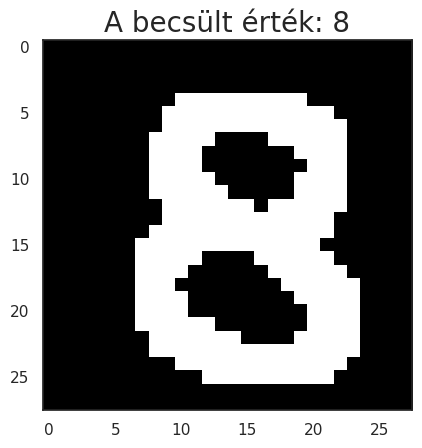

In [59]:
img = image.imread('black_28x28.png')

data = pd.DataFrame([list(img[i,:,0]) for i in range(28)])

temp = test[0:1]

temp2 = img[:,:,0:1]

temp[0] = temp2

results = model.predict(temp)

results = results.T

pred = -1
for i,j in zip(range(len(results)), results):
    if(j==max(results)):
        pred=i

plt.title('A becsült érték: '+str(pred), fontsize=20)
plt.imshow(img)